In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from transformers import RobertaTokenizer, RobertaModel
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import DataLoader, Subset
from scipy.stats import pearsonr
from tqdm import tqdm
from sklearn.exceptions import FitFailedWarning
import warnings
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib
from sklearn.base import clone


In [ ]:
import numpy as np
import pandas as pd

# 读取 .npy 文件
labels = np.load("all_fold_labels.npy", allow_pickle=True)

probs = np.load("all_fold_probs.npy", allow_pickle=True)

# 确保数据是一维的
labels = np.concatenate(labels) if isinstance(labels, list) else labels.ravel()

probs = np.concatenate(probs) if isinstance(probs, list) else probs.ravel()

# 创建 DataFrame
df = pd.DataFrame({
    "y": labels,
    "y_prob": probs
})

# 保存为 CSV 文件
csv_filename = "ChemBERTa_misclassified_samples.csv"
df.to_csv(csv_filename, index=False)

print(f"CSV 文件已保存: {csv_filename}")

In [24]:
import pandas as pd
from rdkit import Chem

# 读取数据
data = pd.read_csv("./imputed_selected_features_Toxicity.csv")
data = data.dropna()  # 删除缺失值
smiles_data = data['SMILES'].tolist()



In [25]:
import torch

# 检查是否有可用的 GPU
if torch.cuda.is_available():
    print("CUDA 可用，GPU 可用。")
    print(f"CUDA 版本: {torch.version.cuda}")
    print(f"GPU 数量: {torch.cuda.device_count()}")
    print(f"当前设备名称: {torch.cuda.get_device_name(0)}")
    print(f"当前设备总内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CUDA 不可用，仅支持 CPU。")


CUDA 可用，GPU 可用。
CUDA 版本: 12.1
GPU 数量: 1
当前设备名称: NVIDIA vGPU-32GB
当前设备总内存: 31.48 GB


In [26]:
labels_Toxicity=data['Toxicity'].tolist()

In [27]:
labels = labels_Toxicity

In [28]:
# 数据增强函数：简单的 SMILES 序列翻转
def augment_smiles(smiles):
    """简单的数据增强方法，例如旋转 SMILES 字符串"""
    if random.random() > 0.5:
        return smiles[::-1]  # 翻转字符串
    return smiles



class SMILES_Dataset(Dataset):
    def __init__(self, smiles, class_labels):
        self.smiles = smiles  # SMILES字符串列表
        self.class_labels = class_labels  # 分类任务标签

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        # smiles = augment_smiles(self.smiles[idx])  # 如果需要数据增强，可以启用这行
        smiles = self.smiles[idx]  # 获取单个SMILES
        class_label = self.class_labels[idx]  # 获取对应的分类标签
        tokens = tokenizer(smiles, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return tokens, torch.tensor(class_label, dtype=torch.long)



class ChemBERTa_Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ChemBERTa_Classifier, self).__init__()
        # 加载预训练的ChemBERTa模型
        self.chemberta = chemberta_model  # 假设chemberta_model已定义
        hidden_size = self.chemberta.config.hidden_size  # 一般为768

        # 分类任务的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, tokens):
        output = self.chemberta(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  # [CLS] token 嵌入
        class_output = self.classifier(cls_embedding)  # 分类任务输出
        return class_output

In [29]:
# 加载 ChemBERTa 模型和 tokenizer
model_name = "../ChemBERTa"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
chemberta_model = RobertaModel.from_pretrained(model_name)

In [30]:
# 假设 num_classes 已经定义，表示分类任务的类别数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用类别数来初始化分类器模型
model = ChemBERTa_Classifier(num_classes=2).to(device)  # 这里假设是4分类任务，您可以根据需要调整类别数

In [31]:
from torch.utils.data import DataLoader, random_split
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import joblib

# 定义 K 折交叉验证的折数
K_FOLDS = 5
num_epochs = 50
batch_size = 32

# 分类任务的损失函数
class_criterion = nn.CrossEntropyLoss()

# 记录所有折的训练损失和准确率
all_train_losses = []
all_val_losses = []
all_train_accuracies = []
all_val_accuracies = []
all_fold_preds = []
all_fold_probs = []
all_fold_labels = []

# 使用 Stratified K-Fold 交叉验证
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=22)

for fold, (train_idx, val_idx) in enumerate(skf.split(smiles_data, labels)):
    print(f"\n===== Fold {fold+1}/{K_FOLDS} =====")

    # 创建本折的训练集和验证集
    train_dataset = Subset(SMILES_Dataset(smiles_data, labels), train_idx)
    val_dataset = Subset(SMILES_Dataset(smiles_data, labels), val_idx)

    # 生成数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    # 初始化模型（确保每一折都有一个新的模型）
    # 假设 num_classes 已经定义，表示分类任务的类别数
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 使用类别数来初始化分类器模型
    # 加载 ChemBERTa 模型和 tokenizer
    model_name = "../ChemBERTa"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    chemberta_model = RobertaModel.from_pretrained(model_name)
    model = ChemBERTa_Classifier(num_classes=2).to(device)  # 这里假设是4分类任务，您可以根据需要调整类别数
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

    # 记录当前折的训练和验证损失、准确率
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_class_loss = 0.0
        correct_class_preds = 0
        total_class_preds = 0

        # 训练过程
        train_loader_tqdm = tqdm(train_loader, desc=f"Fold {fold+1} | Epoch [{epoch+1}/{num_epochs}] - Training")
        for tokens, class_labels in train_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            class_output = model(tokens)

            # 计算损失
            class_loss = class_criterion(class_output, class_labels)
            class_loss.backward()
            optimizer.step()

            running_class_loss += class_loss.item()

            # 计算分类准确率
            _, predicted = torch.max(class_output, 1)
            correct_class_preds += (predicted == class_labels).sum().item()
            total_class_preds += class_labels.size(0)

            # 在 tqdm 显示分类损失
            train_loader_tqdm.set_postfix({'Class Loss': class_loss.item()})

        avg_class_loss = running_class_loss / len(train_loader)
        train_accuracy = correct_class_preds / total_class_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Class Loss: {avg_class_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # 保存训练损失和准确率
        train_losses.append(avg_class_loss)
        train_accuracies.append(train_accuracy)

        # 评估模型
        model.eval()
        val_class_loss = 0.0
        correct_class_preds = 0
        total_class_preds = 0

        val_loader_tqdm = tqdm(val_loader, desc=f"Fold {fold+1} | Epoch [{epoch+1}/{num_epochs}] - Validation")
        with torch.no_grad():
            for tokens, class_labels in val_loader_tqdm:
                tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
                class_labels = class_labels.to(device)

                # 前向传播
                class_output = model(tokens)

                # 计算损失
                class_loss = class_criterion(class_output, class_labels)
                val_class_loss += class_loss.item()

                # 计算分类准确率
                _, predicted = torch.max(class_output, 1)
                correct_class_preds += (predicted == class_labels).sum().item()
                total_class_preds += class_labels.size(0)

            avg_val_class_loss = val_class_loss / len(val_loader)
            val_accuracy = correct_class_preds / total_class_preds
            print(f"Epoch [{epoch+1}/{num_epochs}], Val Class Loss: {avg_val_class_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # 保存验证损失和准确率
            val_losses.append(avg_val_class_loss)
            val_accuracies.append(val_accuracy)

    
    # 确保模型在评估模式
    model.eval()
    
    # 存储真实标签和预测结果
    all_preds = []
    all_probs = []
    all_labels = []
    
    # 遍历测试集进行预测
    test_loader_tqdm = tqdm(val_loader, desc="Testing")
    with torch.no_grad():
        for tokens, class_labels in test_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)
    
            # 预测
            class_output = model(tokens)
            probs = torch.softmax(class_output, dim=1)  # 获取概率分布
            _, predicted = torch.max(class_output, 1)  # 获取类别预测结果
    
            all_probs.extend(probs[:, 1].cpu().numpy())  # 取出正类的概率
            all_preds.extend(predicted.cpu().numpy())  # 取出预测类别
            all_labels.extend(class_labels.cpu().numpy())  # 真实标签
    
    # 转换为 numpy 数组
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_fold_preds.append(all_preds)
    all_fold_probs.append(all_probs)
    all_fold_labels.append(all_labels)
    
    
    from sklearn.metrics import precision_recall_curve, auc
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    roc_auc = roc_auc_score(all_labels, all_probs)
    # 计算 Precision-Recall 曲线
    precisions, recalls, _ = precision_recall_curve(all_labels, all_probs)
    
    # 计算 PR-AUC
    pr_auc = auc(recalls, precisions)
    
    # 输出所有评估指标
    print(f"Fold {fold+1}Test Accuracy: {accuracy:.4f}")
    print(f"Fold {fold+1}Test Precision: {precision:.4f}")
    print(f"Fold {fold+1}Test Recall: {recall:.4f}")
    print(f"Fold {fold+1}Test F1 Score: {f1:.4f}")
    print(f"Fold {fold+1}Test ROC-AUC: {roc_auc:.4f}")
    print(f"Fold {fold+1}Test PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC
    
    # 计算混淆矩阵
    conf_matrix_test = confusion_matrix(all_labels, all_preds)
    print(conf_matrix_test)

    # 保存所有折的训练过程数据
    results = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }


    joblib.dump(results, f"Fold {fold+1}  cross_validation_results.pkl")
    # 保存当前折的模型
    model_path = f"bert_classifier_fold{fold+1}.pt"
    torch.save(model.state_dict(), model_path)
    print(f"Model for Fold {fold+1} saved to {model_path}\n")

# 结束 K 折交叉验证
print("\n===== K-Fold Cross-Validation Completed! =====")




===== Fold 1/5 =====


Fold 1 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.723]


Epoch [1/50], Train Class Loss: 0.7424, Train Accuracy: 0.5239


Fold 1 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.39it/s]


Epoch [1/50], Val Class Loss: 0.6877, Val Accuracy: 0.4844


Fold 1 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.695]


Epoch [2/50], Train Class Loss: 0.7014, Train Accuracy: 0.5662


Fold 1 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.07it/s]


Epoch [2/50], Val Class Loss: 0.6037, Val Accuracy: 0.7188


Fold 1 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.39it/s, Class Loss=0.632]


Epoch [3/50], Train Class Loss: 0.6732, Train Accuracy: 0.5919


Fold 1 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.75it/s]


Epoch [3/50], Val Class Loss: 0.6492, Val Accuracy: 0.6016


Fold 1 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.41it/s, Class Loss=0.716]


Epoch [4/50], Train Class Loss: 0.6606, Train Accuracy: 0.6121


Fold 1 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.38it/s]


Epoch [4/50], Val Class Loss: 0.6623, Val Accuracy: 0.5938


Fold 1 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.666]


Epoch [5/50], Train Class Loss: 0.6914, Train Accuracy: 0.5938


Fold 1 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [5/50], Val Class Loss: 0.6551, Val Accuracy: 0.6016


Fold 1 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.36it/s, Class Loss=0.515]


Epoch [6/50], Train Class Loss: 0.6405, Train Accuracy: 0.6287


Fold 1 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s]


Epoch [6/50], Val Class Loss: 0.6167, Val Accuracy: 0.6719


Fold 1 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.626]


Epoch [7/50], Train Class Loss: 0.6298, Train Accuracy: 0.6507


Fold 1 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.71it/s]


Epoch [7/50], Val Class Loss: 0.5852, Val Accuracy: 0.7422


Fold 1 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.40it/s, Class Loss=0.617]


Epoch [8/50], Train Class Loss: 0.6087, Train Accuracy: 0.6562


Fold 1 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch [8/50], Val Class Loss: 0.5667, Val Accuracy: 0.7109


Fold 1 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.38it/s, Class Loss=0.561]


Epoch [9/50], Train Class Loss: 0.6126, Train Accuracy: 0.6838


Fold 1 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.66it/s]


Epoch [9/50], Val Class Loss: 0.5765, Val Accuracy: 0.7422


Fold 1 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.562]


Epoch [10/50], Train Class Loss: 0.6060, Train Accuracy: 0.6765


Fold 1 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.30it/s]


Epoch [10/50], Val Class Loss: 0.6062, Val Accuracy: 0.7109


Fold 1 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.563]


Epoch [11/50], Train Class Loss: 0.6064, Train Accuracy: 0.6820


Fold 1 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.70it/s]


Epoch [11/50], Val Class Loss: 0.5732, Val Accuracy: 0.7109


Fold 1 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.488]


Epoch [12/50], Train Class Loss: 0.5922, Train Accuracy: 0.6875


Fold 1 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.27it/s]


Epoch [12/50], Val Class Loss: 0.5789, Val Accuracy: 0.6953


Fold 1 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.35it/s, Class Loss=0.678]


Epoch [13/50], Train Class Loss: 0.5970, Train Accuracy: 0.6912


Fold 1 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.05it/s]


Epoch [13/50], Val Class Loss: 0.5655, Val Accuracy: 0.7344


Fold 1 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.466]


Epoch [14/50], Train Class Loss: 0.5539, Train Accuracy: 0.7261


Fold 1 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.17it/s]


Epoch [14/50], Val Class Loss: 0.5838, Val Accuracy: 0.6953


Fold 1 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.447]


Epoch [15/50], Train Class Loss: 0.5670, Train Accuracy: 0.7077


Fold 1 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.42it/s]


Epoch [15/50], Val Class Loss: 0.5425, Val Accuracy: 0.7500


Fold 1 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.661]


Epoch [16/50], Train Class Loss: 0.5354, Train Accuracy: 0.7408


Fold 1 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.16it/s]


Epoch [16/50], Val Class Loss: 0.5291, Val Accuracy: 0.7812


Fold 1 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.567]


Epoch [17/50], Train Class Loss: 0.5286, Train Accuracy: 0.7592


Fold 1 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.26it/s]


Epoch [17/50], Val Class Loss: 0.5349, Val Accuracy: 0.7891


Fold 1 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.573]


Epoch [18/50], Train Class Loss: 0.5378, Train Accuracy: 0.7445


Fold 1 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.78it/s]


Epoch [18/50], Val Class Loss: 0.5818, Val Accuracy: 0.7578


Fold 1 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.44] 


Epoch [19/50], Train Class Loss: 0.5187, Train Accuracy: 0.7537


Fold 1 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [19/50], Val Class Loss: 0.5850, Val Accuracy: 0.7734


Fold 1 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.392]


Epoch [20/50], Train Class Loss: 0.5121, Train Accuracy: 0.7500


Fold 1 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.63it/s]


Epoch [20/50], Val Class Loss: 0.5475, Val Accuracy: 0.7891


Fold 1 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.621]


Epoch [21/50], Train Class Loss: 0.4973, Train Accuracy: 0.7684


Fold 1 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.51it/s]


Epoch [21/50], Val Class Loss: 0.5409, Val Accuracy: 0.8125


Fold 1 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.486]


Epoch [22/50], Train Class Loss: 0.5046, Train Accuracy: 0.7629


Fold 1 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.01it/s]


Epoch [22/50], Val Class Loss: 0.5849, Val Accuracy: 0.7812


Fold 1 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.346]


Epoch [23/50], Train Class Loss: 0.4754, Train Accuracy: 0.7978


Fold 1 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.58it/s]


Epoch [23/50], Val Class Loss: 0.5697, Val Accuracy: 0.7969


Fold 1 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.343]


Epoch [24/50], Train Class Loss: 0.4864, Train Accuracy: 0.8033


Fold 1 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s]


Epoch [24/50], Val Class Loss: 0.5320, Val Accuracy: 0.8125


Fold 1 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.663]


Epoch [25/50], Train Class Loss: 0.4695, Train Accuracy: 0.8033


Fold 1 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.78it/s]


Epoch [25/50], Val Class Loss: 0.5681, Val Accuracy: 0.8125


Fold 1 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.15it/s, Class Loss=0.41] 


Epoch [26/50], Train Class Loss: 0.4537, Train Accuracy: 0.8309


Fold 1 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.03it/s]


Epoch [26/50], Val Class Loss: 0.5587, Val Accuracy: 0.8047


Fold 1 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.331]


Epoch [27/50], Train Class Loss: 0.4168, Train Accuracy: 0.8290


Fold 1 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.40it/s]


Epoch [27/50], Val Class Loss: 0.5857, Val Accuracy: 0.8125


Fold 1 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.315]


Epoch [28/50], Train Class Loss: 0.4306, Train Accuracy: 0.8346


Fold 1 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s]


Epoch [28/50], Val Class Loss: 0.4882, Val Accuracy: 0.8516


Fold 1 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.546]


Epoch [29/50], Train Class Loss: 0.4177, Train Accuracy: 0.8603


Fold 1 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.06it/s]


Epoch [29/50], Val Class Loss: 0.5535, Val Accuracy: 0.8359


Fold 1 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.292]


Epoch [30/50], Train Class Loss: 0.4029, Train Accuracy: 0.8548


Fold 1 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [30/50], Val Class Loss: 0.5188, Val Accuracy: 0.8359


Fold 1 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.413]


Epoch [31/50], Train Class Loss: 0.3912, Train Accuracy: 0.8603


Fold 1 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.34it/s]


Epoch [31/50], Val Class Loss: 0.5423, Val Accuracy: 0.8438


Fold 1 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.429]


Epoch [32/50], Train Class Loss: 0.3648, Train Accuracy: 0.8952


Fold 1 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.54it/s]


Epoch [32/50], Val Class Loss: 0.5973, Val Accuracy: 0.8438


Fold 1 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.361]


Epoch [33/50], Train Class Loss: 0.3592, Train Accuracy: 0.8897


Fold 1 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.57it/s]


Epoch [33/50], Val Class Loss: 0.5251, Val Accuracy: 0.8359


Fold 1 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.3]  


Epoch [34/50], Train Class Loss: 0.3270, Train Accuracy: 0.9320


Fold 1 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.12it/s]


Epoch [34/50], Val Class Loss: 0.5598, Val Accuracy: 0.8438


Fold 1 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.223]


Epoch [35/50], Train Class Loss: 0.3328, Train Accuracy: 0.9081


Fold 1 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.43it/s]


Epoch [35/50], Val Class Loss: 0.5376, Val Accuracy: 0.8359


Fold 1 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.221]


Epoch [36/50], Train Class Loss: 0.3022, Train Accuracy: 0.9246


Fold 1 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.33it/s]


Epoch [36/50], Val Class Loss: 0.5498, Val Accuracy: 0.8359


Fold 1 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.302]


Epoch [37/50], Train Class Loss: 0.2869, Train Accuracy: 0.9485


Fold 1 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.93it/s]


Epoch [37/50], Val Class Loss: 0.5390, Val Accuracy: 0.8516


Fold 1 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.262]


Epoch [38/50], Train Class Loss: 0.2686, Train Accuracy: 0.9540


Fold 1 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.65it/s]


Epoch [38/50], Val Class Loss: 0.5062, Val Accuracy: 0.8672


Fold 1 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.191]


Epoch [39/50], Train Class Loss: 0.2977, Train Accuracy: 0.9338


Fold 1 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.59it/s]


Epoch [39/50], Val Class Loss: 0.5484, Val Accuracy: 0.8438


Fold 1 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.338]


Epoch [40/50], Train Class Loss: 0.2456, Train Accuracy: 0.9632


Fold 1 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.33it/s]


Epoch [40/50], Val Class Loss: 0.5924, Val Accuracy: 0.8125


Fold 1 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.42] 


Epoch [41/50], Train Class Loss: 0.2599, Train Accuracy: 0.9540


Fold 1 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.28it/s]


Epoch [41/50], Val Class Loss: 0.5392, Val Accuracy: 0.8281


Fold 1 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.279]


Epoch [42/50], Train Class Loss: 0.2454, Train Accuracy: 0.9596


Fold 1 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.39it/s]


Epoch [42/50], Val Class Loss: 0.4891, Val Accuracy: 0.8516


Fold 1 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.247] 


Epoch [43/50], Train Class Loss: 0.2362, Train Accuracy: 0.9706


Fold 1 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [43/50], Val Class Loss: 0.5829, Val Accuracy: 0.8203


Fold 1 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.188]


Epoch [44/50], Train Class Loss: 0.2311, Train Accuracy: 0.9724


Fold 1 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [44/50], Val Class Loss: 0.5152, Val Accuracy: 0.8672


Fold 1 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.381]


Epoch [45/50], Train Class Loss: 0.2125, Train Accuracy: 0.9779


Fold 1 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.55it/s]


Epoch [45/50], Val Class Loss: 0.5265, Val Accuracy: 0.8594


Fold 1 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.167] 


Epoch [46/50], Train Class Loss: 0.2161, Train Accuracy: 0.9743


Fold 1 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [46/50], Val Class Loss: 0.5204, Val Accuracy: 0.8594


Fold 1 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.333]


Epoch [47/50], Train Class Loss: 0.2135, Train Accuracy: 0.9871


Fold 1 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.60it/s]


Epoch [47/50], Val Class Loss: 0.5463, Val Accuracy: 0.8672


Fold 1 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.128]


Epoch [48/50], Train Class Loss: 0.2084, Train Accuracy: 0.9871


Fold 1 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.86it/s]


Epoch [48/50], Val Class Loss: 0.5936, Val Accuracy: 0.8438


Fold 1 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.314] 


Epoch [49/50], Train Class Loss: 0.2130, Train Accuracy: 0.9798


Fold 1 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [49/50], Val Class Loss: 0.5924, Val Accuracy: 0.8594


Fold 1 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.153]


Epoch [50/50], Train Class Loss: 0.1846, Train Accuracy: 0.9816


Fold 1 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.59it/s]


Epoch [50/50], Val Class Loss: 0.5915, Val Accuracy: 0.8594


Testing: 100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Fold 1Test Accuracy: 0.8594
Fold 1Test Precision: 0.9211
Fold 1Test Recall: 0.9211
Fold 1Test F1 Score: 0.9211
Fold 1Test ROC-AUC: 0.7162
Fold 1Test PR-AUC: 0.9406
[[  5   9]
 [  9 105]]
Model for Fold 1 saved to bert_classifier_fold1.pt


===== Fold 2/5 =====


Fold 2 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.771]


Epoch [1/50], Train Class Loss: 0.8311, Train Accuracy: 0.4798


Fold 2 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.10it/s]


Epoch [1/50], Val Class Loss: 0.8725, Val Accuracy: 0.1562


Fold 2 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.745]


Epoch [2/50], Train Class Loss: 0.7979, Train Accuracy: 0.5092


Fold 2 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.29it/s]


Epoch [2/50], Val Class Loss: 0.8630, Val Accuracy: 0.3906


Fold 2 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.742]


Epoch [3/50], Train Class Loss: 0.7975, Train Accuracy: 0.5018


Fold 2 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.58it/s]


Epoch [3/50], Val Class Loss: 0.8448, Val Accuracy: 0.3906


Fold 2 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.794]


Epoch [4/50], Train Class Loss: 0.7778, Train Accuracy: 0.5110


Fold 2 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.72it/s]


Epoch [4/50], Val Class Loss: 0.7771, Val Accuracy: 0.4766


Fold 2 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.714]


Epoch [5/50], Train Class Loss: 0.7778, Train Accuracy: 0.4945


Fold 2 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.54it/s]


Epoch [5/50], Val Class Loss: 0.7677, Val Accuracy: 0.5000


Fold 2 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.772]


Epoch [6/50], Train Class Loss: 0.7479, Train Accuracy: 0.5478


Fold 2 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.67it/s]


Epoch [6/50], Val Class Loss: 0.7790, Val Accuracy: 0.5000


Fold 2 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.75] 


Epoch [7/50], Train Class Loss: 0.7272, Train Accuracy: 0.5607


Fold 2 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.76it/s]


Epoch [7/50], Val Class Loss: 0.7942, Val Accuracy: 0.4922


Fold 2 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.848]


Epoch [8/50], Train Class Loss: 0.7288, Train Accuracy: 0.5772


Fold 2 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.20it/s]


Epoch [8/50], Val Class Loss: 0.7935, Val Accuracy: 0.5156


Fold 2 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.813]


Epoch [9/50], Train Class Loss: 0.7299, Train Accuracy: 0.5717


Fold 2 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.26it/s]


Epoch [9/50], Val Class Loss: 0.7881, Val Accuracy: 0.5312


Fold 2 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.782]


Epoch [10/50], Train Class Loss: 0.7249, Train Accuracy: 0.5901


Fold 2 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Epoch [10/50], Val Class Loss: 0.7527, Val Accuracy: 0.6016


Fold 2 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.702]


Epoch [11/50], Train Class Loss: 0.7293, Train Accuracy: 0.5478


Fold 2 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.89it/s]


Epoch [11/50], Val Class Loss: 0.7128, Val Accuracy: 0.5859


Fold 2 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.866]


Epoch [12/50], Train Class Loss: 0.7091, Train Accuracy: 0.5882


Fold 2 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.34it/s]


Epoch [12/50], Val Class Loss: 0.6734, Val Accuracy: 0.6406


Fold 2 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.713]


Epoch [13/50], Train Class Loss: 0.7059, Train Accuracy: 0.5772


Fold 2 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.74it/s]


Epoch [13/50], Val Class Loss: 0.7259, Val Accuracy: 0.5938


Fold 2 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.78] 


Epoch [14/50], Train Class Loss: 0.7043, Train Accuracy: 0.5772


Fold 2 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch [14/50], Val Class Loss: 0.7410, Val Accuracy: 0.5703


Fold 2 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.517]


Epoch [15/50], Train Class Loss: 0.6944, Train Accuracy: 0.5993


Fold 2 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.72it/s]


Epoch [15/50], Val Class Loss: 0.7298, Val Accuracy: 0.6094


Fold 2 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.739]


Epoch [16/50], Train Class Loss: 0.6840, Train Accuracy: 0.6103


Fold 2 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.77it/s]


Epoch [16/50], Val Class Loss: 0.7525, Val Accuracy: 0.6016


Fold 2 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.748]


Epoch [17/50], Train Class Loss: 0.6752, Train Accuracy: 0.6250


Fold 2 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.25it/s]


Epoch [17/50], Val Class Loss: 0.7427, Val Accuracy: 0.5859


Fold 2 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.722]


Epoch [18/50], Train Class Loss: 0.6641, Train Accuracy: 0.6121


Fold 2 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [18/50], Val Class Loss: 0.7206, Val Accuracy: 0.6094


Fold 2 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.633]


Epoch [19/50], Train Class Loss: 0.6364, Train Accuracy: 0.6471


Fold 2 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.98it/s]


Epoch [19/50], Val Class Loss: 0.7299, Val Accuracy: 0.6250


Fold 2 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.767]


Epoch [20/50], Train Class Loss: 0.6275, Train Accuracy: 0.6728


Fold 2 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.83it/s]


Epoch [20/50], Val Class Loss: 0.7678, Val Accuracy: 0.6406


Fold 2 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.611]


Epoch [21/50], Train Class Loss: 0.6732, Train Accuracy: 0.6489


Fold 2 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]


Epoch [21/50], Val Class Loss: 0.6915, Val Accuracy: 0.7344


Fold 2 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.567]


Epoch [22/50], Train Class Loss: 0.6227, Train Accuracy: 0.6581


Fold 2 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.74it/s]


Epoch [22/50], Val Class Loss: 0.6389, Val Accuracy: 0.7578


Fold 2 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.754]


Epoch [23/50], Train Class Loss: 0.6188, Train Accuracy: 0.6562


Fold 2 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.15it/s]


Epoch [23/50], Val Class Loss: 0.7591, Val Accuracy: 0.7031


Fold 2 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.445]


Epoch [24/50], Train Class Loss: 0.6155, Train Accuracy: 0.6875


Fold 2 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.81it/s]


Epoch [24/50], Val Class Loss: 0.7418, Val Accuracy: 0.7109


Fold 2 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.546]


Epoch [25/50], Train Class Loss: 0.6241, Train Accuracy: 0.6783


Fold 2 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [25/50], Val Class Loss: 0.7068, Val Accuracy: 0.7344


Fold 2 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.797]


Epoch [26/50], Train Class Loss: 0.5919, Train Accuracy: 0.7096


Fold 2 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.92it/s]


Epoch [26/50], Val Class Loss: 0.6349, Val Accuracy: 0.7812


Fold 2 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.508]


Epoch [27/50], Train Class Loss: 0.5643, Train Accuracy: 0.7298


Fold 2 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.16it/s]


Epoch [27/50], Val Class Loss: 0.6735, Val Accuracy: 0.7031


Fold 2 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.569]


Epoch [28/50], Train Class Loss: 0.5752, Train Accuracy: 0.7096


Fold 2 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.73it/s]


Epoch [28/50], Val Class Loss: 0.6097, Val Accuracy: 0.7734


Fold 2 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.403]


Epoch [29/50], Train Class Loss: 0.5997, Train Accuracy: 0.7206


Fold 2 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.77it/s]


Epoch [29/50], Val Class Loss: 0.6163, Val Accuracy: 0.8047


Fold 2 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.357]


Epoch [30/50], Train Class Loss: 0.5615, Train Accuracy: 0.7261


Fold 2 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.57it/s]


Epoch [30/50], Val Class Loss: 0.6750, Val Accuracy: 0.7734


Fold 2 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.10it/s, Class Loss=0.58] 


Epoch [31/50], Train Class Loss: 0.5462, Train Accuracy: 0.7390


Fold 2 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.65it/s]


Epoch [31/50], Val Class Loss: 0.6069, Val Accuracy: 0.7969


Fold 2 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.501]


Epoch [32/50], Train Class Loss: 0.5420, Train Accuracy: 0.7463


Fold 2 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]


Epoch [32/50], Val Class Loss: 0.5850, Val Accuracy: 0.8438


Fold 2 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.8]  


Epoch [33/50], Train Class Loss: 0.5331, Train Accuracy: 0.7629


Fold 2 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.37it/s]


Epoch [33/50], Val Class Loss: 0.6425, Val Accuracy: 0.7969


Fold 2 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.511]


Epoch [34/50], Train Class Loss: 0.5040, Train Accuracy: 0.7702


Fold 2 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.48it/s]


Epoch [34/50], Val Class Loss: 0.5706, Val Accuracy: 0.7969


Fold 2 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.431]


Epoch [35/50], Train Class Loss: 0.5268, Train Accuracy: 0.7482


Fold 2 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.37it/s]


Epoch [35/50], Val Class Loss: 0.6338, Val Accuracy: 0.7812


Fold 2 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.463]


Epoch [36/50], Train Class Loss: 0.4660, Train Accuracy: 0.7978


Fold 2 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.55it/s]


Epoch [36/50], Val Class Loss: 0.5104, Val Accuracy: 0.8359


Fold 2 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.279]


Epoch [37/50], Train Class Loss: 0.4613, Train Accuracy: 0.7978


Fold 2 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.42it/s]


Epoch [37/50], Val Class Loss: 0.5558, Val Accuracy: 0.8203


Fold 2 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.367]


Epoch [38/50], Train Class Loss: 0.4626, Train Accuracy: 0.8088


Fold 2 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.08it/s]


Epoch [38/50], Val Class Loss: 0.5517, Val Accuracy: 0.8516


Fold 2 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.666]


Epoch [39/50], Train Class Loss: 0.4354, Train Accuracy: 0.8290


Fold 2 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.36it/s]


Epoch [39/50], Val Class Loss: 0.5486, Val Accuracy: 0.8359


Fold 2 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.231]


Epoch [40/50], Train Class Loss: 0.4269, Train Accuracy: 0.8401


Fold 2 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.91it/s]


Epoch [40/50], Val Class Loss: 0.5913, Val Accuracy: 0.8125


Fold 2 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.23] 


Epoch [41/50], Train Class Loss: 0.4198, Train Accuracy: 0.8511


Fold 2 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.57it/s]


Epoch [41/50], Val Class Loss: 0.5331, Val Accuracy: 0.8516


Fold 2 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.625]


Epoch [42/50], Train Class Loss: 0.3974, Train Accuracy: 0.8621


Fold 2 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.76it/s]


Epoch [42/50], Val Class Loss: 0.5466, Val Accuracy: 0.8359


Fold 2 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.342]


Epoch [43/50], Train Class Loss: 0.3548, Train Accuracy: 0.8842


Fold 2 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s]


Epoch [43/50], Val Class Loss: 0.5481, Val Accuracy: 0.8516


Fold 2 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.287]


Epoch [44/50], Train Class Loss: 0.3414, Train Accuracy: 0.8989


Fold 2 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.58it/s]


Epoch [44/50], Val Class Loss: 0.5307, Val Accuracy: 0.8516


Fold 2 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.278]


Epoch [45/50], Train Class Loss: 0.3330, Train Accuracy: 0.9081


Fold 2 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.82it/s]


Epoch [45/50], Val Class Loss: 0.5306, Val Accuracy: 0.8672


Fold 2 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.4]  


Epoch [46/50], Train Class Loss: 0.3252, Train Accuracy: 0.9173


Fold 2 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.60it/s]


Epoch [46/50], Val Class Loss: 0.6302, Val Accuracy: 0.8438


Fold 2 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.44] 


Epoch [47/50], Train Class Loss: 0.3211, Train Accuracy: 0.9191


Fold 2 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.62it/s]


Epoch [47/50], Val Class Loss: 0.5285, Val Accuracy: 0.8594


Fold 2 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.261]


Epoch [48/50], Train Class Loss: 0.3257, Train Accuracy: 0.9191


Fold 2 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.62it/s]


Epoch [48/50], Val Class Loss: 0.5564, Val Accuracy: 0.8438


Fold 2 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.909]


Epoch [49/50], Train Class Loss: 0.3508, Train Accuracy: 0.8897


Fold 2 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.39it/s]


Epoch [49/50], Val Class Loss: 0.5159, Val Accuracy: 0.8594


Fold 2 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.424]


Epoch [50/50], Train Class Loss: 0.2809, Train Accuracy: 0.9357


Fold 2 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.72it/s]


Epoch [50/50], Val Class Loss: 0.5891, Val Accuracy: 0.8359


Testing: 100%|██████████| 4/4 [00:00<00:00, 44.78it/s]


Fold 2Test Accuracy: 0.8359
Fold 2Test Precision: 0.9429
Fold 2Test Recall: 0.8684
Fold 2Test F1 Score: 0.9041
Fold 2Test ROC-AUC: 0.7644
Fold 2Test PR-AUC: 0.9513
[[ 8  6]
 [15 99]]
Model for Fold 2 saved to bert_classifier_fold2.pt


===== Fold 3/5 =====


Fold 3 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.724]


Epoch [1/50], Train Class Loss: 0.7712, Train Accuracy: 0.5221


Fold 3 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.71it/s]


Epoch [1/50], Val Class Loss: 0.6561, Val Accuracy: 0.6250


Fold 3 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.763]


Epoch [2/50], Train Class Loss: 0.7309, Train Accuracy: 0.5423


Fold 3 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Epoch [2/50], Val Class Loss: 0.6235, Val Accuracy: 0.6797


Fold 3 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.639]


Epoch [3/50], Train Class Loss: 0.7255, Train Accuracy: 0.5331


Fold 3 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.98it/s]


Epoch [3/50], Val Class Loss: 0.6181, Val Accuracy: 0.7188


Fold 3 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.709]


Epoch [4/50], Train Class Loss: 0.7031, Train Accuracy: 0.5790


Fold 3 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.91it/s]


Epoch [4/50], Val Class Loss: 0.6073, Val Accuracy: 0.6953


Fold 3 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.736]


Epoch [5/50], Train Class Loss: 0.6818, Train Accuracy: 0.5717


Fold 3 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.24it/s]


Epoch [5/50], Val Class Loss: 0.6073, Val Accuracy: 0.7188


Fold 3 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.725]


Epoch [6/50], Train Class Loss: 0.6739, Train Accuracy: 0.6029


Fold 3 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.08it/s]


Epoch [6/50], Val Class Loss: 0.6234, Val Accuracy: 0.7031


Fold 3 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.71] 


Epoch [7/50], Train Class Loss: 0.6804, Train Accuracy: 0.6287


Fold 3 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]


Epoch [7/50], Val Class Loss: 0.6370, Val Accuracy: 0.6875


Fold 3 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.75] 


Epoch [8/50], Train Class Loss: 0.6548, Train Accuracy: 0.6287


Fold 3 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.27it/s]


Epoch [8/50], Val Class Loss: 0.6069, Val Accuracy: 0.7344


Fold 3 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.32it/s, Class Loss=0.665]


Epoch [9/50], Train Class Loss: 0.6551, Train Accuracy: 0.6232


Fold 3 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.58it/s]


Epoch [9/50], Val Class Loss: 0.6152, Val Accuracy: 0.7109


Fold 3 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.16it/s, Class Loss=0.657]


Epoch [10/50], Train Class Loss: 0.6581, Train Accuracy: 0.6158


Fold 3 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.60it/s]


Epoch [10/50], Val Class Loss: 0.6609, Val Accuracy: 0.6719


Fold 3 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.653]


Epoch [11/50], Train Class Loss: 0.6357, Train Accuracy: 0.6471


Fold 3 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch [11/50], Val Class Loss: 0.6280, Val Accuracy: 0.7500


Fold 3 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.712]


Epoch [12/50], Train Class Loss: 0.6055, Train Accuracy: 0.6801


Fold 3 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.21it/s]


Epoch [12/50], Val Class Loss: 0.6127, Val Accuracy: 0.7031


Fold 3 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.56] 


Epoch [13/50], Train Class Loss: 0.6130, Train Accuracy: 0.6783


Fold 3 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]


Epoch [13/50], Val Class Loss: 0.5961, Val Accuracy: 0.7344


Fold 3 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.517]


Epoch [14/50], Train Class Loss: 0.5822, Train Accuracy: 0.7114


Fold 3 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.39it/s]


Epoch [14/50], Val Class Loss: 0.5678, Val Accuracy: 0.7500


Fold 3 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.653]


Epoch [15/50], Train Class Loss: 0.6132, Train Accuracy: 0.6581


Fold 3 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.24it/s]


Epoch [15/50], Val Class Loss: 0.6109, Val Accuracy: 0.7109


Fold 3 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.548]


Epoch [16/50], Train Class Loss: 0.5897, Train Accuracy: 0.6875


Fold 3 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.74it/s]


Epoch [16/50], Val Class Loss: 0.5511, Val Accuracy: 0.7578


Fold 3 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.686]


Epoch [17/50], Train Class Loss: 0.5736, Train Accuracy: 0.7077


Fold 3 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.25it/s]


Epoch [17/50], Val Class Loss: 0.5837, Val Accuracy: 0.7344


Fold 3 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.538]


Epoch [18/50], Train Class Loss: 0.5667, Train Accuracy: 0.7335


Fold 3 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.96it/s]


Epoch [18/50], Val Class Loss: 0.5921, Val Accuracy: 0.7500


Fold 3 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.52] 


Epoch [19/50], Train Class Loss: 0.5677, Train Accuracy: 0.7463


Fold 3 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.18it/s]


Epoch [19/50], Val Class Loss: 0.6252, Val Accuracy: 0.7188


Fold 3 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.487]


Epoch [20/50], Train Class Loss: 0.5509, Train Accuracy: 0.7353


Fold 3 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.92it/s]


Epoch [20/50], Val Class Loss: 0.5530, Val Accuracy: 0.7891


Fold 3 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.489]


Epoch [21/50], Train Class Loss: 0.5440, Train Accuracy: 0.7188


Fold 3 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.83it/s]


Epoch [21/50], Val Class Loss: 0.5799, Val Accuracy: 0.7422


Fold 3 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.354]


Epoch [22/50], Train Class Loss: 0.5198, Train Accuracy: 0.7868


Fold 3 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [22/50], Val Class Loss: 0.5475, Val Accuracy: 0.7734


Fold 3 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.739]


Epoch [23/50], Train Class Loss: 0.5077, Train Accuracy: 0.7592


Fold 3 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Epoch [23/50], Val Class Loss: 0.5810, Val Accuracy: 0.7656


Fold 3 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.731]


Epoch [24/50], Train Class Loss: 0.5036, Train Accuracy: 0.7665


Fold 3 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.60it/s]


Epoch [24/50], Val Class Loss: 0.5906, Val Accuracy: 0.7578


Fold 3 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.475]


Epoch [25/50], Train Class Loss: 0.4692, Train Accuracy: 0.8033


Fold 3 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.09it/s]


Epoch [25/50], Val Class Loss: 0.5695, Val Accuracy: 0.7891


Fold 3 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.443]


Epoch [26/50], Train Class Loss: 0.4448, Train Accuracy: 0.8217


Fold 3 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.85it/s]


Epoch [26/50], Val Class Loss: 0.5315, Val Accuracy: 0.7969


Fold 3 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.291]


Epoch [27/50], Train Class Loss: 0.4261, Train Accuracy: 0.8676


Fold 3 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.79it/s]


Epoch [27/50], Val Class Loss: 0.5430, Val Accuracy: 0.8203


Fold 3 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.495]


Epoch [28/50], Train Class Loss: 0.4168, Train Accuracy: 0.8493


Fold 3 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [28/50], Val Class Loss: 0.5797, Val Accuracy: 0.7891


Fold 3 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.374]


Epoch [29/50], Train Class Loss: 0.4343, Train Accuracy: 0.8401


Fold 3 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s]


Epoch [29/50], Val Class Loss: 0.5156, Val Accuracy: 0.8359


Fold 3 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.389]


Epoch [30/50], Train Class Loss: 0.3990, Train Accuracy: 0.8768


Fold 3 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [30/50], Val Class Loss: 0.5759, Val Accuracy: 0.8047


Fold 3 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.319]


Epoch [31/50], Train Class Loss: 0.3608, Train Accuracy: 0.9062


Fold 3 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.83it/s]


Epoch [31/50], Val Class Loss: 0.5227, Val Accuracy: 0.8516


Fold 3 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.587]


Epoch [32/50], Train Class Loss: 0.3547, Train Accuracy: 0.9007


Fold 3 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.74it/s]


Epoch [32/50], Val Class Loss: 0.5530, Val Accuracy: 0.8438


Fold 3 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.304]


Epoch [33/50], Train Class Loss: 0.3426, Train Accuracy: 0.9154


Fold 3 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.86it/s]


Epoch [33/50], Val Class Loss: 0.5115, Val Accuracy: 0.8594


Fold 3 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.365]


Epoch [34/50], Train Class Loss: 0.3359, Train Accuracy: 0.9246


Fold 3 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [34/50], Val Class Loss: 0.5711, Val Accuracy: 0.8359


Fold 3 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.283]


Epoch [35/50], Train Class Loss: 0.3377, Train Accuracy: 0.9062


Fold 3 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.76it/s]


Epoch [35/50], Val Class Loss: 0.6278, Val Accuracy: 0.8359


Fold 3 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.247]


Epoch [36/50], Train Class Loss: 0.2984, Train Accuracy: 0.9485


Fold 3 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.96it/s]


Epoch [36/50], Val Class Loss: 0.5279, Val Accuracy: 0.8672


Fold 3 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.228]


Epoch [37/50], Train Class Loss: 0.3136, Train Accuracy: 0.9228


Fold 3 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.77it/s]


Epoch [37/50], Val Class Loss: 0.5118, Val Accuracy: 0.8594


Fold 3 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.873]


Epoch [38/50], Train Class Loss: 0.3323, Train Accuracy: 0.9265


Fold 3 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.98it/s]


Epoch [38/50], Val Class Loss: 0.4776, Val Accuracy: 0.8438


Fold 3 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.362]


Epoch [39/50], Train Class Loss: 0.2730, Train Accuracy: 0.9449


Fold 3 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.98it/s]


Epoch [39/50], Val Class Loss: 0.5002, Val Accuracy: 0.8516


Fold 3 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.249]


Epoch [40/50], Train Class Loss: 0.2690, Train Accuracy: 0.9577


Fold 3 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]


Epoch [40/50], Val Class Loss: 0.4739, Val Accuracy: 0.8750


Fold 3 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.326]


Epoch [41/50], Train Class Loss: 0.2832, Train Accuracy: 0.9651


Fold 3 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.00it/s]


Epoch [41/50], Val Class Loss: 0.5877, Val Accuracy: 0.8516


Fold 3 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.111]


Epoch [42/50], Train Class Loss: 0.3178, Train Accuracy: 0.9136


Fold 3 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s]


Epoch [42/50], Val Class Loss: 0.3799, Val Accuracy: 0.9062


Fold 3 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.257]


Epoch [43/50], Train Class Loss: 0.2628, Train Accuracy: 0.9669


Fold 3 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.43it/s]


Epoch [43/50], Val Class Loss: 0.5589, Val Accuracy: 0.8359


Fold 3 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.0903]


Epoch [44/50], Train Class Loss: 0.2638, Train Accuracy: 0.9632


Fold 3 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.36it/s]


Epoch [44/50], Val Class Loss: 0.6612, Val Accuracy: 0.8359


Fold 3 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.226]


Epoch [45/50], Train Class Loss: 0.2561, Train Accuracy: 0.9485


Fold 3 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.24it/s]


Epoch [45/50], Val Class Loss: 0.5328, Val Accuracy: 0.8594


Fold 3 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.139]


Epoch [46/50], Train Class Loss: 0.2739, Train Accuracy: 0.9449


Fold 3 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.46it/s]


Epoch [46/50], Val Class Loss: 0.5418, Val Accuracy: 0.8594


Fold 3 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.302]


Epoch [47/50], Train Class Loss: 0.2388, Train Accuracy: 0.9632


Fold 3 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.53it/s]


Epoch [47/50], Val Class Loss: 0.5659, Val Accuracy: 0.8516


Fold 3 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.218]


Epoch [48/50], Train Class Loss: 0.2200, Train Accuracy: 0.9651


Fold 3 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.17it/s]


Epoch [48/50], Val Class Loss: 0.6435, Val Accuracy: 0.8594


Fold 3 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.124]


Epoch [49/50], Train Class Loss: 0.1895, Train Accuracy: 0.9926


Fold 3 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.41it/s]


Epoch [49/50], Val Class Loss: 0.5973, Val Accuracy: 0.8594


Fold 3 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.115] 


Epoch [50/50], Train Class Loss: 0.2183, Train Accuracy: 0.9651


Fold 3 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.26it/s]


Epoch [50/50], Val Class Loss: 0.5375, Val Accuracy: 0.8750


Testing: 100%|██████████| 4/4 [00:00<00:00, 44.82it/s]


Fold 3Test Accuracy: 0.8750
Fold 3Test Precision: 0.9304
Fold 3Test Recall: 0.9304
Fold 3Test F1 Score: 0.9304
Fold 3Test ROC-AUC: 0.6863
Fold 3Test PR-AUC: 0.9212
[[  5   8]
 [  8 107]]
Model for Fold 3 saved to bert_classifier_fold3.pt


===== Fold 4/5 =====


Fold 4 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.716]


Epoch [1/50], Train Class Loss: 0.7697, Train Accuracy: 0.4926


Fold 4 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.62it/s]


Epoch [1/50], Val Class Loss: 0.8017, Val Accuracy: 0.2344


Fold 4 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.14it/s, Class Loss=0.725]


Epoch [2/50], Train Class Loss: 0.7122, Train Accuracy: 0.5441


Fold 4 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.34it/s]


Epoch [2/50], Val Class Loss: 0.8183, Val Accuracy: 0.3672


Fold 4 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.732]


Epoch [3/50], Train Class Loss: 0.7287, Train Accuracy: 0.5386


Fold 4 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s]


Epoch [3/50], Val Class Loss: 0.7954, Val Accuracy: 0.4375


Fold 4 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.656]


Epoch [4/50], Train Class Loss: 0.6930, Train Accuracy: 0.5864


Fold 4 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [4/50], Val Class Loss: 0.7960, Val Accuracy: 0.4766


Fold 4 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.71] 


Epoch [5/50], Train Class Loss: 0.7091, Train Accuracy: 0.5662


Fold 4 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.32it/s]


Epoch [5/50], Val Class Loss: 0.7763, Val Accuracy: 0.5391


Fold 4 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.706]


Epoch [6/50], Train Class Loss: 0.6754, Train Accuracy: 0.5882


Fold 4 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.26it/s]


Epoch [6/50], Val Class Loss: 0.7836, Val Accuracy: 0.5234


Fold 4 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.725]


Epoch [7/50], Train Class Loss: 0.6716, Train Accuracy: 0.6195


Fold 4 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.95it/s]


Epoch [7/50], Val Class Loss: 0.8103, Val Accuracy: 0.5156


Fold 4 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.78] 


Epoch [8/50], Train Class Loss: 0.6942, Train Accuracy: 0.5974


Fold 4 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.26it/s]


Epoch [8/50], Val Class Loss: 0.7683, Val Accuracy: 0.5625


Fold 4 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.682]


Epoch [9/50], Train Class Loss: 0.6468, Train Accuracy: 0.6287


Fold 4 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [9/50], Val Class Loss: 0.7538, Val Accuracy: 0.6094


Fold 4 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.542]


Epoch [10/50], Train Class Loss: 0.6398, Train Accuracy: 0.6176


Fold 4 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.70it/s]


Epoch [10/50], Val Class Loss: 0.7612, Val Accuracy: 0.5938


Fold 4 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.606]


Epoch [11/50], Train Class Loss: 0.6494, Train Accuracy: 0.6526


Fold 4 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.28it/s]


Epoch [11/50], Val Class Loss: 0.7573, Val Accuracy: 0.6094


Fold 4 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.695]


Epoch [12/50], Train Class Loss: 0.6501, Train Accuracy: 0.6379


Fold 4 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.64it/s]


Epoch [12/50], Val Class Loss: 0.7084, Val Accuracy: 0.6641


Fold 4 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.549]


Epoch [13/50], Train Class Loss: 0.6175, Train Accuracy: 0.6838


Fold 4 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.99it/s]


Epoch [13/50], Val Class Loss: 0.7505, Val Accuracy: 0.5938


Fold 4 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.684]


Epoch [14/50], Train Class Loss: 0.6544, Train Accuracy: 0.6158


Fold 4 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch [14/50], Val Class Loss: 0.7090, Val Accuracy: 0.6328


Fold 4 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.589]


Epoch [15/50], Train Class Loss: 0.6125, Train Accuracy: 0.6691


Fold 4 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.87it/s]


Epoch [15/50], Val Class Loss: 0.6895, Val Accuracy: 0.6328


Fold 4 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.712]


Epoch [16/50], Train Class Loss: 0.6083, Train Accuracy: 0.6654


Fold 4 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.03it/s]


Epoch [16/50], Val Class Loss: 0.7175, Val Accuracy: 0.6250


Fold 4 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.725]


Epoch [17/50], Train Class Loss: 0.6143, Train Accuracy: 0.6636


Fold 4 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.18it/s]


Epoch [17/50], Val Class Loss: 0.7793, Val Accuracy: 0.6016


Fold 4 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.509]


Epoch [18/50], Train Class Loss: 0.6197, Train Accuracy: 0.6636


Fold 4 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [18/50], Val Class Loss: 0.7286, Val Accuracy: 0.6484


Fold 4 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.394]


Epoch [19/50], Train Class Loss: 0.5755, Train Accuracy: 0.6930


Fold 4 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.12it/s]


Epoch [19/50], Val Class Loss: 0.6819, Val Accuracy: 0.6953


Fold 4 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.591]


Epoch [20/50], Train Class Loss: 0.5807, Train Accuracy: 0.7096


Fold 4 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.61it/s]


Epoch [20/50], Val Class Loss: 0.7667, Val Accuracy: 0.6641


Fold 4 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.605]


Epoch [21/50], Train Class Loss: 0.5424, Train Accuracy: 0.7243


Fold 4 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [21/50], Val Class Loss: 0.7319, Val Accuracy: 0.6953


Fold 4 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.42it/s, Class Loss=0.387]


Epoch [22/50], Train Class Loss: 0.5254, Train Accuracy: 0.7665


Fold 4 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [22/50], Val Class Loss: 0.7353, Val Accuracy: 0.6875


Fold 4 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.31it/s, Class Loss=0.751]


Epoch [23/50], Train Class Loss: 0.5351, Train Accuracy: 0.7316


Fold 4 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.56it/s]


Epoch [23/50], Val Class Loss: 0.7631, Val Accuracy: 0.6875


Fold 4 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.455]


Epoch [24/50], Train Class Loss: 0.4994, Train Accuracy: 0.7794


Fold 4 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [24/50], Val Class Loss: 0.7612, Val Accuracy: 0.6953


Fold 4 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.551]


Epoch [25/50], Train Class Loss: 0.4964, Train Accuracy: 0.7721


Fold 4 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


Epoch [25/50], Val Class Loss: 0.7927, Val Accuracy: 0.6875


Fold 4 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.599]


Epoch [26/50], Train Class Loss: 0.5041, Train Accuracy: 0.7886


Fold 4 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.48it/s]


Epoch [26/50], Val Class Loss: 0.7653, Val Accuracy: 0.6953


Fold 4 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.311]


Epoch [27/50], Train Class Loss: 0.5045, Train Accuracy: 0.7794


Fold 4 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [27/50], Val Class Loss: 0.8612, Val Accuracy: 0.6875


Fold 4 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.257]


Epoch [28/50], Train Class Loss: 0.4858, Train Accuracy: 0.7904


Fold 4 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.60it/s]


Epoch [28/50], Val Class Loss: 0.8019, Val Accuracy: 0.6953


Fold 4 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.506]


Epoch [29/50], Train Class Loss: 0.4523, Train Accuracy: 0.8033


Fold 4 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.08it/s]


Epoch [29/50], Val Class Loss: 0.7769, Val Accuracy: 0.7266


Fold 4 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.636]


Epoch [30/50], Train Class Loss: 0.4421, Train Accuracy: 0.8254


Fold 4 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.07it/s]


Epoch [30/50], Val Class Loss: 0.8030, Val Accuracy: 0.7266


Fold 4 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.41] 


Epoch [31/50], Train Class Loss: 0.4382, Train Accuracy: 0.8290


Fold 4 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.49it/s]


Epoch [31/50], Val Class Loss: 0.8132, Val Accuracy: 0.7266


Fold 4 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.332]


Epoch [32/50], Train Class Loss: 0.4212, Train Accuracy: 0.8199


Fold 4 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.75it/s]


Epoch [32/50], Val Class Loss: 0.9303, Val Accuracy: 0.7344


Fold 4 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.354]


Epoch [33/50], Train Class Loss: 0.3805, Train Accuracy: 0.8915


Fold 4 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch [33/50], Val Class Loss: 0.7879, Val Accuracy: 0.7734


Fold 4 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.354]


Epoch [34/50], Train Class Loss: 0.4004, Train Accuracy: 0.8676


Fold 4 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [34/50], Val Class Loss: 0.8387, Val Accuracy: 0.7734


Fold 4 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.33it/s, Class Loss=0.397]


Epoch [35/50], Train Class Loss: 0.3489, Train Accuracy: 0.8915


Fold 4 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.09it/s]


Epoch [35/50], Val Class Loss: 0.7735, Val Accuracy: 0.7812


Fold 4 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.218]


Epoch [36/50], Train Class Loss: 0.3452, Train Accuracy: 0.9081


Fold 4 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.52it/s]


Epoch [36/50], Val Class Loss: 0.7403, Val Accuracy: 0.7734


Fold 4 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.09it/s, Class Loss=0.457]


Epoch [37/50], Train Class Loss: 0.3463, Train Accuracy: 0.8989


Fold 4 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.58it/s]


Epoch [37/50], Val Class Loss: 0.8494, Val Accuracy: 0.7734


Fold 4 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.259]


Epoch [38/50], Train Class Loss: 0.3586, Train Accuracy: 0.9062


Fold 4 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.84it/s]


Epoch [38/50], Val Class Loss: 0.7607, Val Accuracy: 0.7891


Fold 4 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.266]


Epoch [39/50], Train Class Loss: 0.3162, Train Accuracy: 0.9062


Fold 4 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.31it/s]


Epoch [39/50], Val Class Loss: 0.9359, Val Accuracy: 0.7422


Fold 4 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.535]


Epoch [40/50], Train Class Loss: 0.2989, Train Accuracy: 0.9412


Fold 4 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.81it/s]


Epoch [40/50], Val Class Loss: 0.7925, Val Accuracy: 0.8047


Fold 4 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.268]


Epoch [41/50], Train Class Loss: 0.2951, Train Accuracy: 0.9504


Fold 4 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 44.52it/s]


Epoch [41/50], Val Class Loss: 0.8110, Val Accuracy: 0.7969


Fold 4 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.26] 


Epoch [42/50], Train Class Loss: 0.3265, Train Accuracy: 0.9265


Fold 4 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [42/50], Val Class Loss: 0.8126, Val Accuracy: 0.7812


Fold 4 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.361]


Epoch [43/50], Train Class Loss: 0.2948, Train Accuracy: 0.9210


Fold 4 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [43/50], Val Class Loss: 0.9554, Val Accuracy: 0.7734


Fold 4 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.302]


Epoch [44/50], Train Class Loss: 0.2757, Train Accuracy: 0.9301


Fold 4 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.19it/s]


Epoch [44/50], Val Class Loss: 0.9310, Val Accuracy: 0.8125


Fold 4 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.159]


Epoch [45/50], Train Class Loss: 0.2657, Train Accuracy: 0.9504


Fold 4 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.67it/s]


Epoch [45/50], Val Class Loss: 0.8087, Val Accuracy: 0.7812


Fold 4 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.166]


Epoch [46/50], Train Class Loss: 0.2542, Train Accuracy: 0.9540


Fold 4 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.10it/s]


Epoch [46/50], Val Class Loss: 0.8630, Val Accuracy: 0.7891


Fold 4 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.478]


Epoch [47/50], Train Class Loss: 0.2631, Train Accuracy: 0.9504


Fold 4 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.30it/s]


Epoch [47/50], Val Class Loss: 0.9299, Val Accuracy: 0.7891


Fold 4 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.166]


Epoch [48/50], Train Class Loss: 0.2411, Train Accuracy: 0.9596


Fold 4 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.27it/s]


Epoch [48/50], Val Class Loss: 0.9902, Val Accuracy: 0.7812


Fold 4 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.34it/s, Class Loss=0.247]


Epoch [49/50], Train Class Loss: 0.2533, Train Accuracy: 0.9596


Fold 4 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.16it/s]


Epoch [49/50], Val Class Loss: 0.8716, Val Accuracy: 0.7812


Fold 4 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.37it/s, Class Loss=0.122]


Epoch [50/50], Train Class Loss: 0.2353, Train Accuracy: 0.9669


Fold 4 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [50/50], Val Class Loss: 0.8288, Val Accuracy: 0.8047


Testing: 100%|██████████| 4/4 [00:00<00:00, 46.17it/s]


Fold 4Test Accuracy: 0.8047
Fold 4Test Precision: 0.8860
Fold 4Test Recall: 0.8938
Fold 4Test F1 Score: 0.8899
Fold 4Test ROC-AUC: 0.4590
Fold 4Test PR-AUC: 0.8700
[[  2  13]
 [ 12 101]]
Model for Fold 4 saved to bert_classifier_fold4.pt


===== Fold 5/5 =====


Fold 5 | Epoch [1/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.29it/s, Class Loss=0.805]


Epoch [1/50], Train Class Loss: 0.8170, Train Accuracy: 0.4926


Fold 5 | Epoch [1/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.32it/s]


Epoch [1/50], Val Class Loss: 0.7139, Val Accuracy: 0.4062


Fold 5 | Epoch [2/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.694]


Epoch [2/50], Train Class Loss: 0.7728, Train Accuracy: 0.5202


Fold 5 | Epoch [2/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.97it/s]


Epoch [2/50], Val Class Loss: 0.7241, Val Accuracy: 0.5391


Fold 5 | Epoch [3/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.42it/s, Class Loss=0.776]


Epoch [3/50], Train Class Loss: 0.7361, Train Accuracy: 0.5643


Fold 5 | Epoch [3/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.47it/s]


Epoch [3/50], Val Class Loss: 0.6984, Val Accuracy: 0.5859


Fold 5 | Epoch [4/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.47it/s, Class Loss=0.687]


Epoch [4/50], Train Class Loss: 0.7391, Train Accuracy: 0.5515


Fold 5 | Epoch [4/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [4/50], Val Class Loss: 0.6966, Val Accuracy: 0.5781


Fold 5 | Epoch [5/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.828]


Epoch [5/50], Train Class Loss: 0.7111, Train Accuracy: 0.5919


Fold 5 | Epoch [5/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


Epoch [5/50], Val Class Loss: 0.6514, Val Accuracy: 0.6406


Fold 5 | Epoch [6/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.677]


Epoch [6/50], Train Class Loss: 0.7175, Train Accuracy: 0.5882


Fold 5 | Epoch [6/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch [6/50], Val Class Loss: 0.6699, Val Accuracy: 0.6641


Fold 5 | Epoch [7/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.63] 


Epoch [7/50], Train Class Loss: 0.7008, Train Accuracy: 0.5790


Fold 5 | Epoch [7/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.90it/s]


Epoch [7/50], Val Class Loss: 0.6430, Val Accuracy: 0.6484


Fold 5 | Epoch [8/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.676]


Epoch [8/50], Train Class Loss: 0.6978, Train Accuracy: 0.6158


Fold 5 | Epoch [8/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.65it/s]


Epoch [8/50], Val Class Loss: 0.6502, Val Accuracy: 0.7031


Fold 5 | Epoch [9/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.643]


Epoch [9/50], Train Class Loss: 0.6856, Train Accuracy: 0.6526


Fold 5 | Epoch [9/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [9/50], Val Class Loss: 0.6966, Val Accuracy: 0.6328


Fold 5 | Epoch [10/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.818]


Epoch [10/50], Train Class Loss: 0.6671, Train Accuracy: 0.6268


Fold 5 | Epoch [10/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.31it/s]


Epoch [10/50], Val Class Loss: 0.6851, Val Accuracy: 0.6328


Fold 5 | Epoch [11/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.511]


Epoch [11/50], Train Class Loss: 0.6603, Train Accuracy: 0.6673


Fold 5 | Epoch [11/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.41it/s]


Epoch [11/50], Val Class Loss: 0.6484, Val Accuracy: 0.6484


Fold 5 | Epoch [12/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.565]


Epoch [12/50], Train Class Loss: 0.6417, Train Accuracy: 0.6507


Fold 5 | Epoch [12/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


Epoch [12/50], Val Class Loss: 0.6459, Val Accuracy: 0.6641


Fold 5 | Epoch [13/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.805]


Epoch [13/50], Train Class Loss: 0.6399, Train Accuracy: 0.6379


Fold 5 | Epoch [13/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.55it/s]


Epoch [13/50], Val Class Loss: 0.5840, Val Accuracy: 0.7578


Fold 5 | Epoch [14/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.488]


Epoch [14/50], Train Class Loss: 0.6115, Train Accuracy: 0.6710


Fold 5 | Epoch [14/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [14/50], Val Class Loss: 0.6219, Val Accuracy: 0.7344


Fold 5 | Epoch [15/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.54] 


Epoch [15/50], Train Class Loss: 0.6302, Train Accuracy: 0.6636


Fold 5 | Epoch [15/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [15/50], Val Class Loss: 0.6829, Val Accuracy: 0.6875


Fold 5 | Epoch [16/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.636]


Epoch [16/50], Train Class Loss: 0.6070, Train Accuracy: 0.6673


Fold 5 | Epoch [16/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.85it/s]


Epoch [16/50], Val Class Loss: 0.6972, Val Accuracy: 0.6719


Fold 5 | Epoch [17/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.559]


Epoch [17/50], Train Class Loss: 0.5801, Train Accuracy: 0.7022


Fold 5 | Epoch [17/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [17/50], Val Class Loss: 0.6411, Val Accuracy: 0.7344


Fold 5 | Epoch [18/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.749]


Epoch [18/50], Train Class Loss: 0.5542, Train Accuracy: 0.7335


Fold 5 | Epoch [18/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.52it/s]


Epoch [18/50], Val Class Loss: 0.6117, Val Accuracy: 0.7422


Fold 5 | Epoch [19/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.413]


Epoch [19/50], Train Class Loss: 0.5413, Train Accuracy: 0.7335


Fold 5 | Epoch [19/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [19/50], Val Class Loss: 0.6118, Val Accuracy: 0.7422


Fold 5 | Epoch [20/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.586]


Epoch [20/50], Train Class Loss: 0.5302, Train Accuracy: 0.7592


Fold 5 | Epoch [20/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.11it/s]


Epoch [20/50], Val Class Loss: 0.6268, Val Accuracy: 0.7656


Fold 5 | Epoch [21/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.404]


Epoch [21/50], Train Class Loss: 0.5415, Train Accuracy: 0.7426


Fold 5 | Epoch [21/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.23it/s]


Epoch [21/50], Val Class Loss: 0.5884, Val Accuracy: 0.8047


Fold 5 | Epoch [22/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.576]


Epoch [22/50], Train Class Loss: 0.5267, Train Accuracy: 0.7574


Fold 5 | Epoch [22/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.21it/s]


Epoch [22/50], Val Class Loss: 0.6339, Val Accuracy: 0.7656


Fold 5 | Epoch [23/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.30it/s, Class Loss=0.375]


Epoch [23/50], Train Class Loss: 0.4889, Train Accuracy: 0.8088


Fold 5 | Epoch [23/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.44it/s]


Epoch [23/50], Val Class Loss: 0.6892, Val Accuracy: 0.7500


Fold 5 | Epoch [24/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.467]


Epoch [24/50], Train Class Loss: 0.4750, Train Accuracy: 0.8143


Fold 5 | Epoch [24/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.38it/s]


Epoch [24/50], Val Class Loss: 0.6281, Val Accuracy: 0.7500


Fold 5 | Epoch [25/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.457]


Epoch [25/50], Train Class Loss: 0.4552, Train Accuracy: 0.8254


Fold 5 | Epoch [25/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.48it/s]


Epoch [25/50], Val Class Loss: 0.5970, Val Accuracy: 0.7969


Fold 5 | Epoch [26/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.439]


Epoch [26/50], Train Class Loss: 0.4474, Train Accuracy: 0.8235


Fold 5 | Epoch [26/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.15it/s]


Epoch [26/50], Val Class Loss: 0.6236, Val Accuracy: 0.8047


Fold 5 | Epoch [27/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.546]


Epoch [27/50], Train Class Loss: 0.4328, Train Accuracy: 0.8456


Fold 5 | Epoch [27/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.17it/s]


Epoch [27/50], Val Class Loss: 0.7705, Val Accuracy: 0.7656


Fold 5 | Epoch [28/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.506]


Epoch [28/50], Train Class Loss: 0.4419, Train Accuracy: 0.8180


Fold 5 | Epoch [28/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.27it/s]


Epoch [28/50], Val Class Loss: 0.6191, Val Accuracy: 0.8047


Fold 5 | Epoch [29/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.22it/s, Class Loss=0.386]


Epoch [29/50], Train Class Loss: 0.4009, Train Accuracy: 0.8566


Fold 5 | Epoch [29/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.45it/s]


Epoch [29/50], Val Class Loss: 0.7817, Val Accuracy: 0.7969


Fold 5 | Epoch [30/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.401]


Epoch [30/50], Train Class Loss: 0.3737, Train Accuracy: 0.8860


Fold 5 | Epoch [30/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.37it/s]


Epoch [30/50], Val Class Loss: 0.7312, Val Accuracy: 0.8125


Fold 5 | Epoch [31/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.433]


Epoch [31/50], Train Class Loss: 0.3748, Train Accuracy: 0.8805


Fold 5 | Epoch [31/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.45it/s]


Epoch [31/50], Val Class Loss: 0.5826, Val Accuracy: 0.8359


Fold 5 | Epoch [32/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.18it/s, Class Loss=0.246]


Epoch [32/50], Train Class Loss: 0.3568, Train Accuracy: 0.8879


Fold 5 | Epoch [32/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.02it/s]


Epoch [32/50], Val Class Loss: 0.6949, Val Accuracy: 0.8047


Fold 5 | Epoch [33/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.208]


Epoch [33/50], Train Class Loss: 0.3339, Train Accuracy: 0.9062


Fold 5 | Epoch [33/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.60it/s]


Epoch [33/50], Val Class Loss: 0.5609, Val Accuracy: 0.8281


Fold 5 | Epoch [34/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.25it/s, Class Loss=0.338]


Epoch [34/50], Train Class Loss: 0.3439, Train Accuracy: 0.9099


Fold 5 | Epoch [34/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.50it/s]


Epoch [34/50], Val Class Loss: 0.6681, Val Accuracy: 0.8203


Fold 5 | Epoch [35/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.299]


Epoch [35/50], Train Class Loss: 0.3302, Train Accuracy: 0.9136


Fold 5 | Epoch [35/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.53it/s]


Epoch [35/50], Val Class Loss: 0.6050, Val Accuracy: 0.8203


Fold 5 | Epoch [36/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.377]


Epoch [36/50], Train Class Loss: 0.2902, Train Accuracy: 0.9320


Fold 5 | Epoch [36/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.57it/s]


Epoch [36/50], Val Class Loss: 0.7310, Val Accuracy: 0.8125


Fold 5 | Epoch [37/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.236]


Epoch [37/50], Train Class Loss: 0.3208, Train Accuracy: 0.9026


Fold 5 | Epoch [37/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.73it/s]


Epoch [37/50], Val Class Loss: 0.7389, Val Accuracy: 0.7969


Fold 5 | Epoch [38/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.273]


Epoch [38/50], Train Class Loss: 0.2977, Train Accuracy: 0.9338


Fold 5 | Epoch [38/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.51it/s]


Epoch [38/50], Val Class Loss: 0.6273, Val Accuracy: 0.8438


Fold 5 | Epoch [39/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.319]


Epoch [39/50], Train Class Loss: 0.3069, Train Accuracy: 0.9228


Fold 5 | Epoch [39/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.29it/s]


Epoch [39/50], Val Class Loss: 0.7752, Val Accuracy: 0.8047


Fold 5 | Epoch [40/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.178]


Epoch [40/50], Train Class Loss: 0.2621, Train Accuracy: 0.9522


Fold 5 | Epoch [40/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.41it/s]


Epoch [40/50], Val Class Loss: 0.5841, Val Accuracy: 0.8438


Fold 5 | Epoch [41/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.27it/s, Class Loss=0.209]


Epoch [41/50], Train Class Loss: 0.2693, Train Accuracy: 0.9522


Fold 5 | Epoch [41/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.36it/s]


Epoch [41/50], Val Class Loss: 0.7633, Val Accuracy: 0.8359


Fold 5 | Epoch [42/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.19it/s, Class Loss=0.0815]


Epoch [42/50], Train Class Loss: 0.2889, Train Accuracy: 0.9283


Fold 5 | Epoch [42/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.41it/s]


Epoch [42/50], Val Class Loss: 0.6241, Val Accuracy: 0.8203


Fold 5 | Epoch [43/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.23it/s, Class Loss=0.175] 


Epoch [43/50], Train Class Loss: 0.2769, Train Accuracy: 0.9430


Fold 5 | Epoch [43/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.45it/s]


Epoch [43/50], Val Class Loss: 0.6401, Val Accuracy: 0.8203


Fold 5 | Epoch [44/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.26it/s, Class Loss=0.197]


Epoch [44/50], Train Class Loss: 0.2561, Train Accuracy: 0.9559


Fold 5 | Epoch [44/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.52it/s]


Epoch [44/50], Val Class Loss: 0.5362, Val Accuracy: 0.8281


Fold 5 | Epoch [45/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.882]


Epoch [45/50], Train Class Loss: 0.2844, Train Accuracy: 0.9301


Fold 5 | Epoch [45/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.24it/s]


Epoch [45/50], Val Class Loss: 0.7938, Val Accuracy: 0.7812


Fold 5 | Epoch [46/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.17it/s, Class Loss=0.223]


Epoch [46/50], Train Class Loss: 0.2383, Train Accuracy: 0.9540


Fold 5 | Epoch [46/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.40it/s]


Epoch [46/50], Val Class Loss: 0.9155, Val Accuracy: 0.7812


Fold 5 | Epoch [47/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.28it/s, Class Loss=0.157] 


Epoch [47/50], Train Class Loss: 0.2063, Train Accuracy: 0.9688


Fold 5 | Epoch [47/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.25it/s]


Epoch [47/50], Val Class Loss: 0.5821, Val Accuracy: 0.8359


Fold 5 | Epoch [48/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.24it/s, Class Loss=0.214]


Epoch [48/50], Train Class Loss: 0.2013, Train Accuracy: 0.9724


Fold 5 | Epoch [48/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 45.78it/s]


Epoch [48/50], Val Class Loss: 0.7634, Val Accuracy: 0.8125


Fold 5 | Epoch [49/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.21it/s, Class Loss=0.112]


Epoch [49/50], Train Class Loss: 0.2119, Train Accuracy: 0.9559


Fold 5 | Epoch [49/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.35it/s]


Epoch [49/50], Val Class Loss: 0.5590, Val Accuracy: 0.8281


Fold 5 | Epoch [50/50] - Training: 100%|██████████| 17/17 [00:01<00:00, 16.20it/s, Class Loss=0.128] 


Epoch [50/50], Train Class Loss: 0.1889, Train Accuracy: 0.9743


Fold 5 | Epoch [50/50] - Validation: 100%|██████████| 4/4 [00:00<00:00, 46.14it/s]


Epoch [50/50], Val Class Loss: 0.6565, Val Accuracy: 0.8047


Testing: 100%|██████████| 4/4 [00:00<00:00, 45.94it/s]


Fold 5Test Accuracy: 0.8047
Fold 5Test Precision: 0.8793
Fold 5Test Recall: 0.9027
Fold 5Test F1 Score: 0.8908
Fold 5Test ROC-AUC: 0.5552
Fold 5Test PR-AUC: 0.8975
[[  1  14]
 [ 11 102]]
Model for Fold 5 saved to bert_classifier_fold5.pt


===== K-Fold Cross-Validation Completed! =====


In [39]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)
all_fold_labels = np.concatenate(all_fold_labels)
all_fold_probs = np.concatenate(all_fold_probs)
all_fold_preds = np.concatenate(all_fold_preds)

from sklearn.metrics import precision_recall_curve, auc
accuracy = accuracy_score(all_fold_labels, all_fold_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_fold_labels, all_fold_preds, average='binary')
roc_auc = roc_auc_score(all_fold_labels, all_fold_probs)
# 计算 Precision-Recall 曲线
precisions, recalls, _ = precision_recall_curve(all_fold_labels, all_fold_probs)

# 计算 PR-AUC
pr_auc = auc(recalls, precisions)

# 输出所有评估指标
print(f"Fold {fold+1}Test Accuracy: {accuracy:.4f}")
print(f"Fold {fold+1}Test Precision: {precision:.4f}")
print(f"Fold {fold+1}Test Recall: {recall:.4f}")
print(f"Fold {fold+1}Test F1 Score: {f1:.4f}")
print(f"Fold {fold+1}Test ROC-AUC: {roc_auc:.4f}")
print(f"Fold {fold+1}Test PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC

# 计算混淆矩阵
conf_matrix_test = confusion_matrix(all_fold_labels, all_fold_preds)
print(conf_matrix_test)

Fold 5Test Accuracy: 0.8359
Fold 5Test Precision: 0.9113
Fold 5Test Recall: 0.9033
Fold 5Test F1 Score: 0.9073
Fold 5Test ROC-AUC: 0.6187
Fold 5Test PR-AUC: 0.9133
[[ 21  50]
 [ 55 514]]


In [51]:
np.save('./all_fold_labels.npy',all_fold_labels)

In [52]:
np.save('./all_fold_preds.npy',all_fold_preds)

In [53]:
np.save('./all_fold_probs.npy',all_fold_probs)

In [54]:

all_fold_preds = []
all_fold_probs = []
all_fold_labels = []

# 使用 Stratified K-Fold 交叉验证
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=22)

for fold, (train_idx, val_idx) in enumerate(skf.split(smiles_data, labels)):
    print(f"\n===== Fold {fold+1}/{K_FOLDS} =====")

    # 创建本折的训练集和验证集
    train_dataset = Subset(SMILES_Dataset(smiles_data, labels), train_idx)
    #val_dataset = Subset(SMILES_Dataset(smiles_data, labels), val_idx)

    # 生成数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    #val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

    # 初始化模型（确保每一折都有一个新的模型）
    # 假设 num_classes 已经定义，表示分类任务的类别数
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # 使用类别数来初始化分类器模型
    # 加载 ChemBERTa 模型和 tokenizer
    model_name = "../ChemBERTa"
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    chemberta_model = RobertaModel.from_pretrained(model_name)
    model = ChemBERTa_Classifier(num_classes=2).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
        # 保存当前折的模型
    model_path = f"bert_classifier_fold{fold+1}.pt"
    # 加载最佳模型
    model.load_state_dict(torch.load(model_path))
    
    # 确保模型在评估模式
    model.eval()
    
    # 存储真实标签和预测结果
    all_preds = []
    all_probs = []
    all_labels = []
    
    # 遍历测试集进行预测
    test_loader_tqdm = tqdm(train_loader, desc="Testing")
    with torch.no_grad():
        for tokens, class_labels in test_loader_tqdm:
            tokens = {key: val.squeeze(1).to(device) for key, val in tokens.items()}
            class_labels = class_labels.to(device)
    
            # 预测
            class_output = model(tokens)
            probs = torch.softmax(class_output, dim=1)  # 获取概率分布
            _, predicted = torch.max(class_output, 1)  # 获取类别预测结果
    
            all_probs.extend(probs[:, 1].cpu().numpy())  # 取出正类的概率
            all_preds.extend(predicted.cpu().numpy())  # 取出预测类别
            all_labels.extend(class_labels.cpu().numpy())  # 真实标签
    
    # 转换为 numpy 数组
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_fold_preds.append(all_preds)
    all_fold_probs.append(all_probs)
    all_fold_labels.append(all_labels)
    


all_fold_labels = np.concatenate(all_fold_labels)
all_fold_probs = np.concatenate(all_fold_probs)
all_fold_preds = np.concatenate(all_fold_preds)


from sklearn.metrics import precision_recall_curve, auc
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_probs)
# 计算 Precision-Recall 曲线
precisions, recalls, _ = precision_recall_curve(all_labels, all_probs)

# 计算 PR-AUC
pr_auc = auc(recalls, precisions)

# 输出所有评估指标
print(f"Fold {fold+1}Train Accuracy: {accuracy:.4f}")
print(f"Fold {fold+1}Train Precision: {precision:.4f}")
print(f"Fold {fold+1}Train Recall: {recall:.4f}")
print(f"Fold {fold+1}Train F1 Score: {f1:.4f}")
print(f"Fold {fold+1}Train ROC-AUC: {roc_auc:.4f}")
print(f"Fold {fold+1}Train PR-AUC: {pr_auc:.4f}")  # 输出 PR-AUC
    





===== Fold 1/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 44.82it/s]



===== Fold 2/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 45.77it/s]



===== Fold 3/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 45.94it/s]



===== Fold 4/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 45.67it/s]



===== Fold 5/5 =====


Testing: 100%|██████████| 17/17 [00:00<00:00, 45.76it/s]

Fold 5Train Accuracy: 1.0000
Fold 5Train Precision: 1.0000
Fold 5Train Recall: 1.0000
Fold 5Train F1 Score: 1.0000
Fold 5Train ROC-AUC: 1.0000
Fold 5Train PR-AUC: 1.0000


In [ ]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)

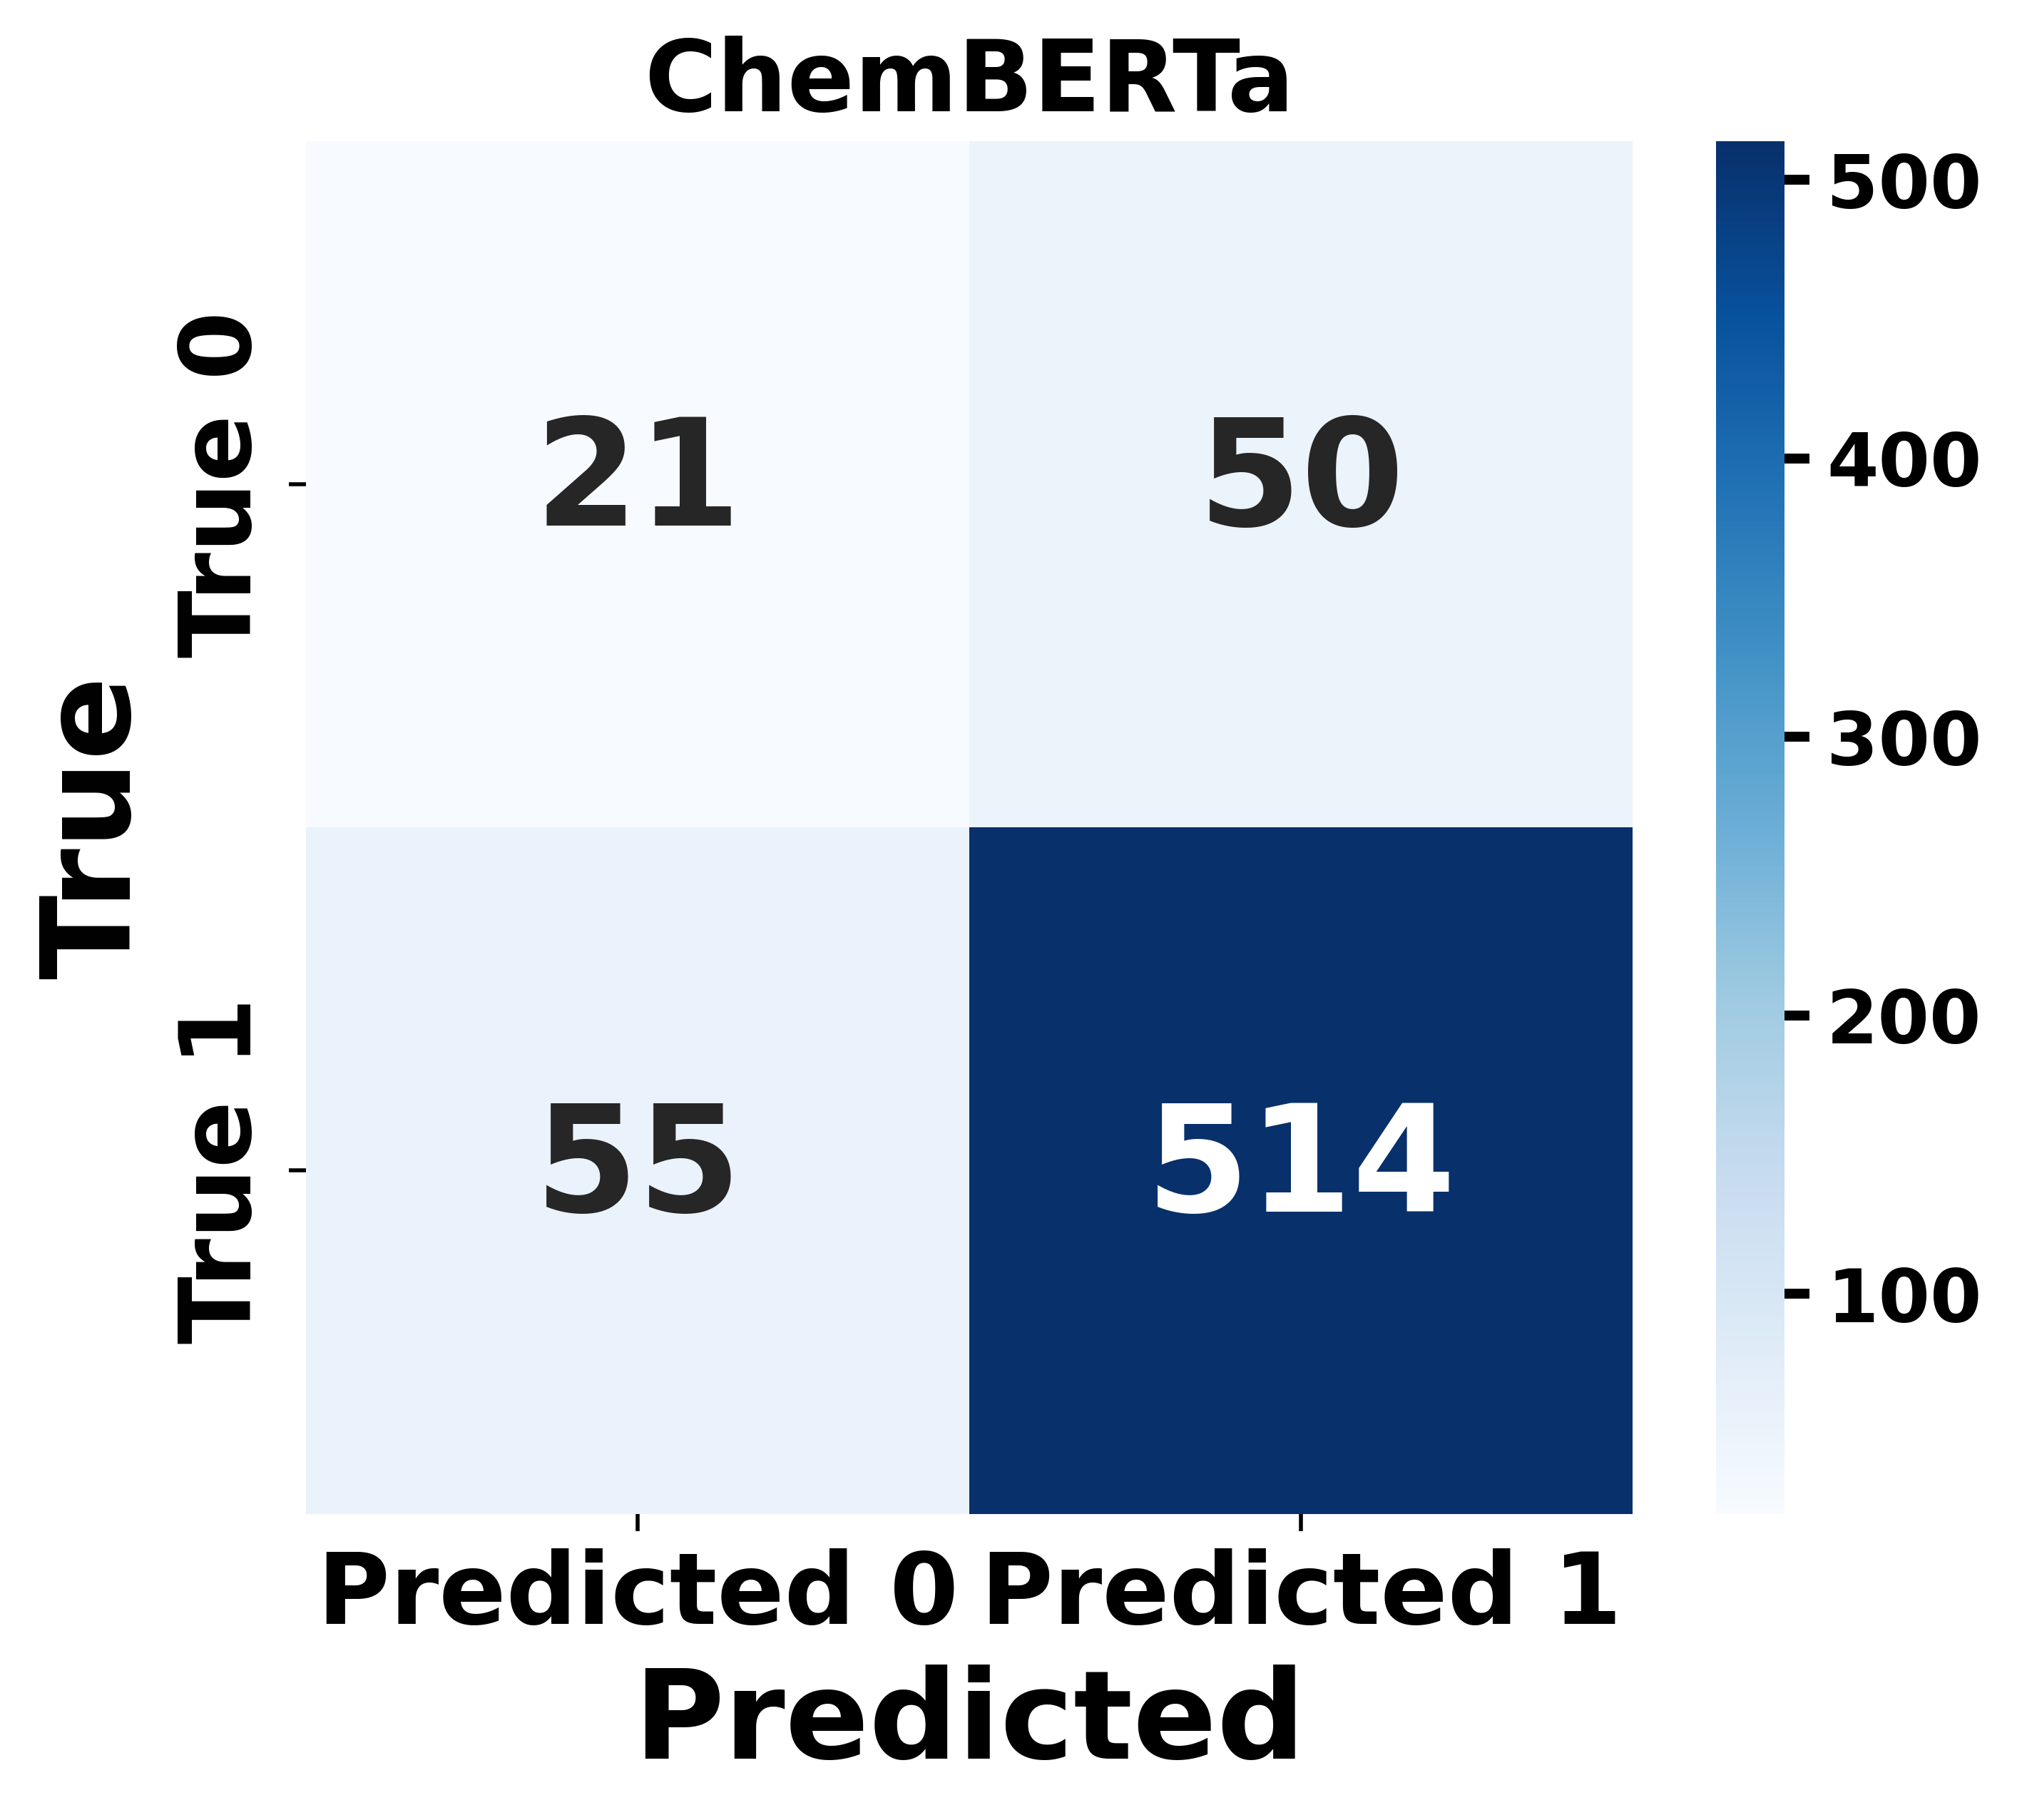

In [50]:

# 绘制热力图
plt.figure(figsize=(6, 5), dpi=500)
ax=sns.heatmap(
    conf_matrix_test, 
    annot=True, 
    fmt='d',
    annot_kws={'fontsize': 30, 'fontweight': 'bold'},  # 加粗数值
    cmap='Blues', 
    xticklabels=['Predicted 0', 'Predicted 1'], 
    yticklabels=['True 0', 'True 1']
)

# 设置标题和标签，并加粗字体
plt.title('ChemBERTa', fontsize=20, fontweight='bold')
plt.xlabel('Predicted', fontsize=25, fontweight='bold')
plt.ylabel('True', fontsize=25, fontweight='bold')

# 调整X/Y轴标签字体大小和加粗
plt.xticks(fontsize=20, fontweight='bold')  
plt.yticks(fontsize=20, fontweight='bold')  
    # 设置颜色条刻度字体加粗
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
for label in cbar.ax.get_yticklabels():
    label.set_fontweight('bold')  # 让刻度标签加粗
#cbar.set_label("Accuracy", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
# 显示图
plt.show()

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

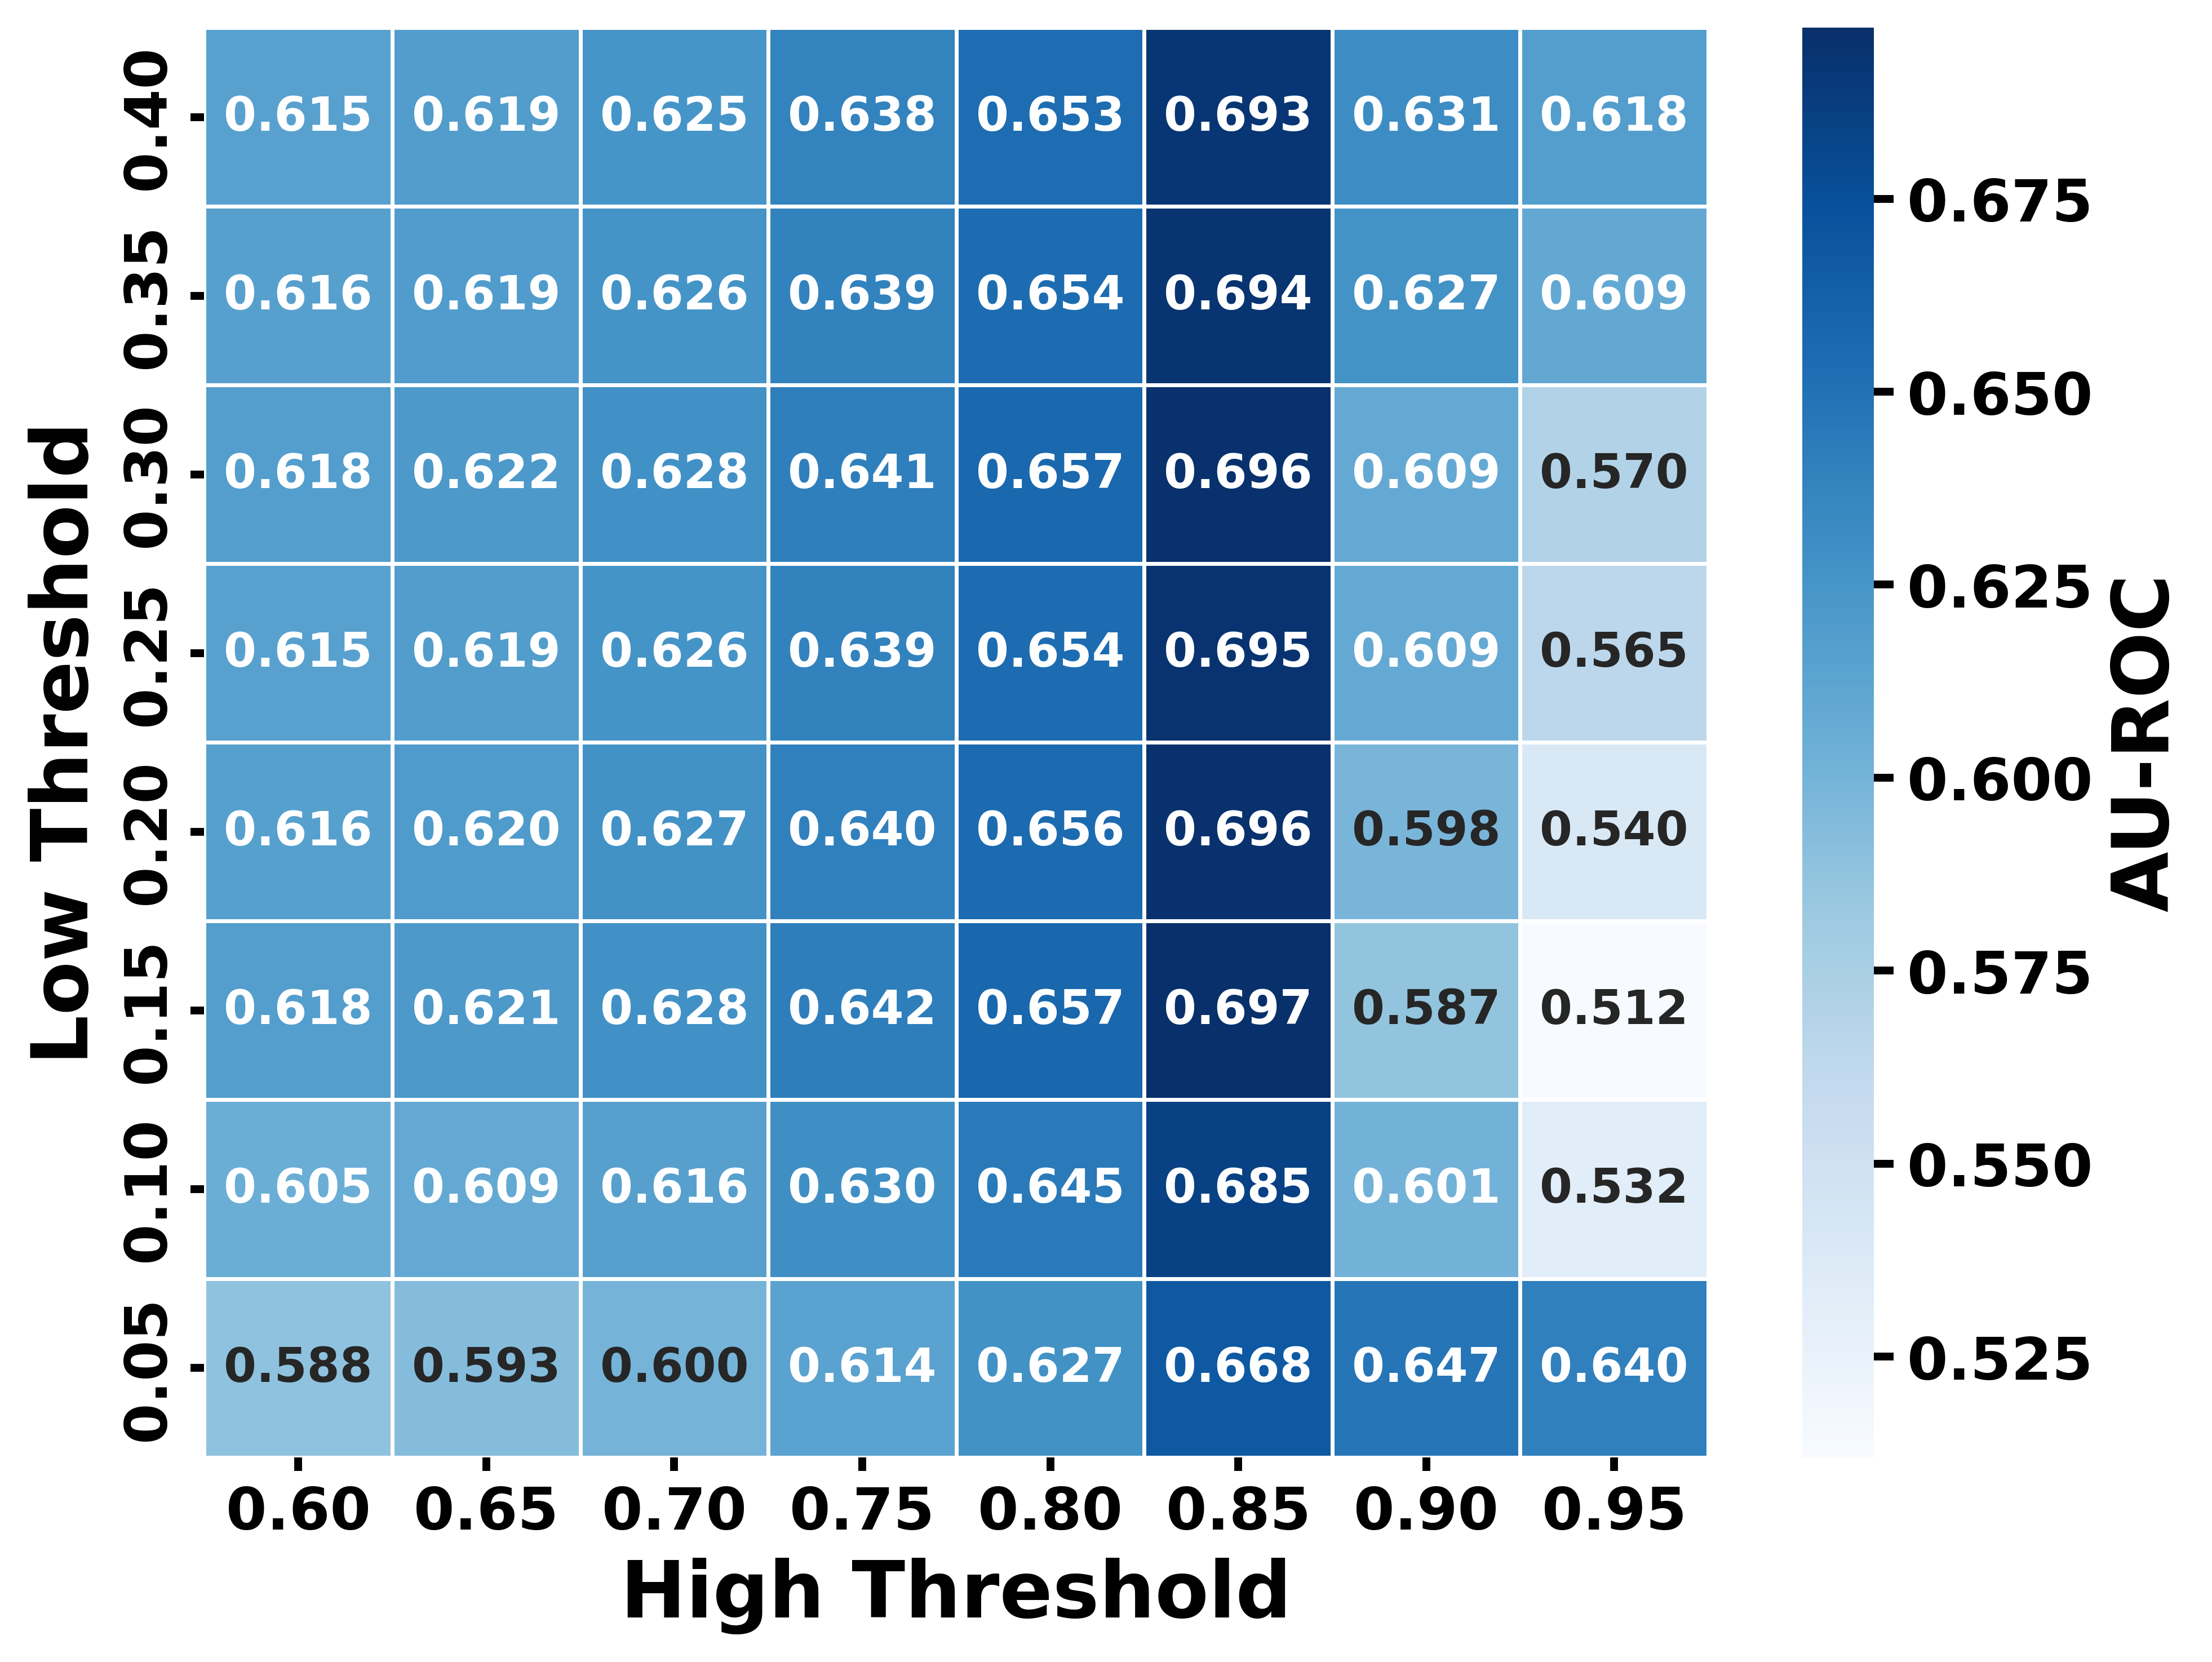

In [44]:
from sklearn.metrics import roc_auc_score

def plot_auroc(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(auc_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(auc_matrix)
    
    yanse = (vmax+vmin)/2

    # 创建带边框的热力图
    ax = sns.heatmap(
        auc_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "AU-ROC"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AU-ROC", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_auroc(all_fold_probs,all_fold_labels)


In [ ]:
# all_fold_preds.append(all_preds)
# all_fold_probs.append(all_probs)
# all_fold_labels.append(all_labels)

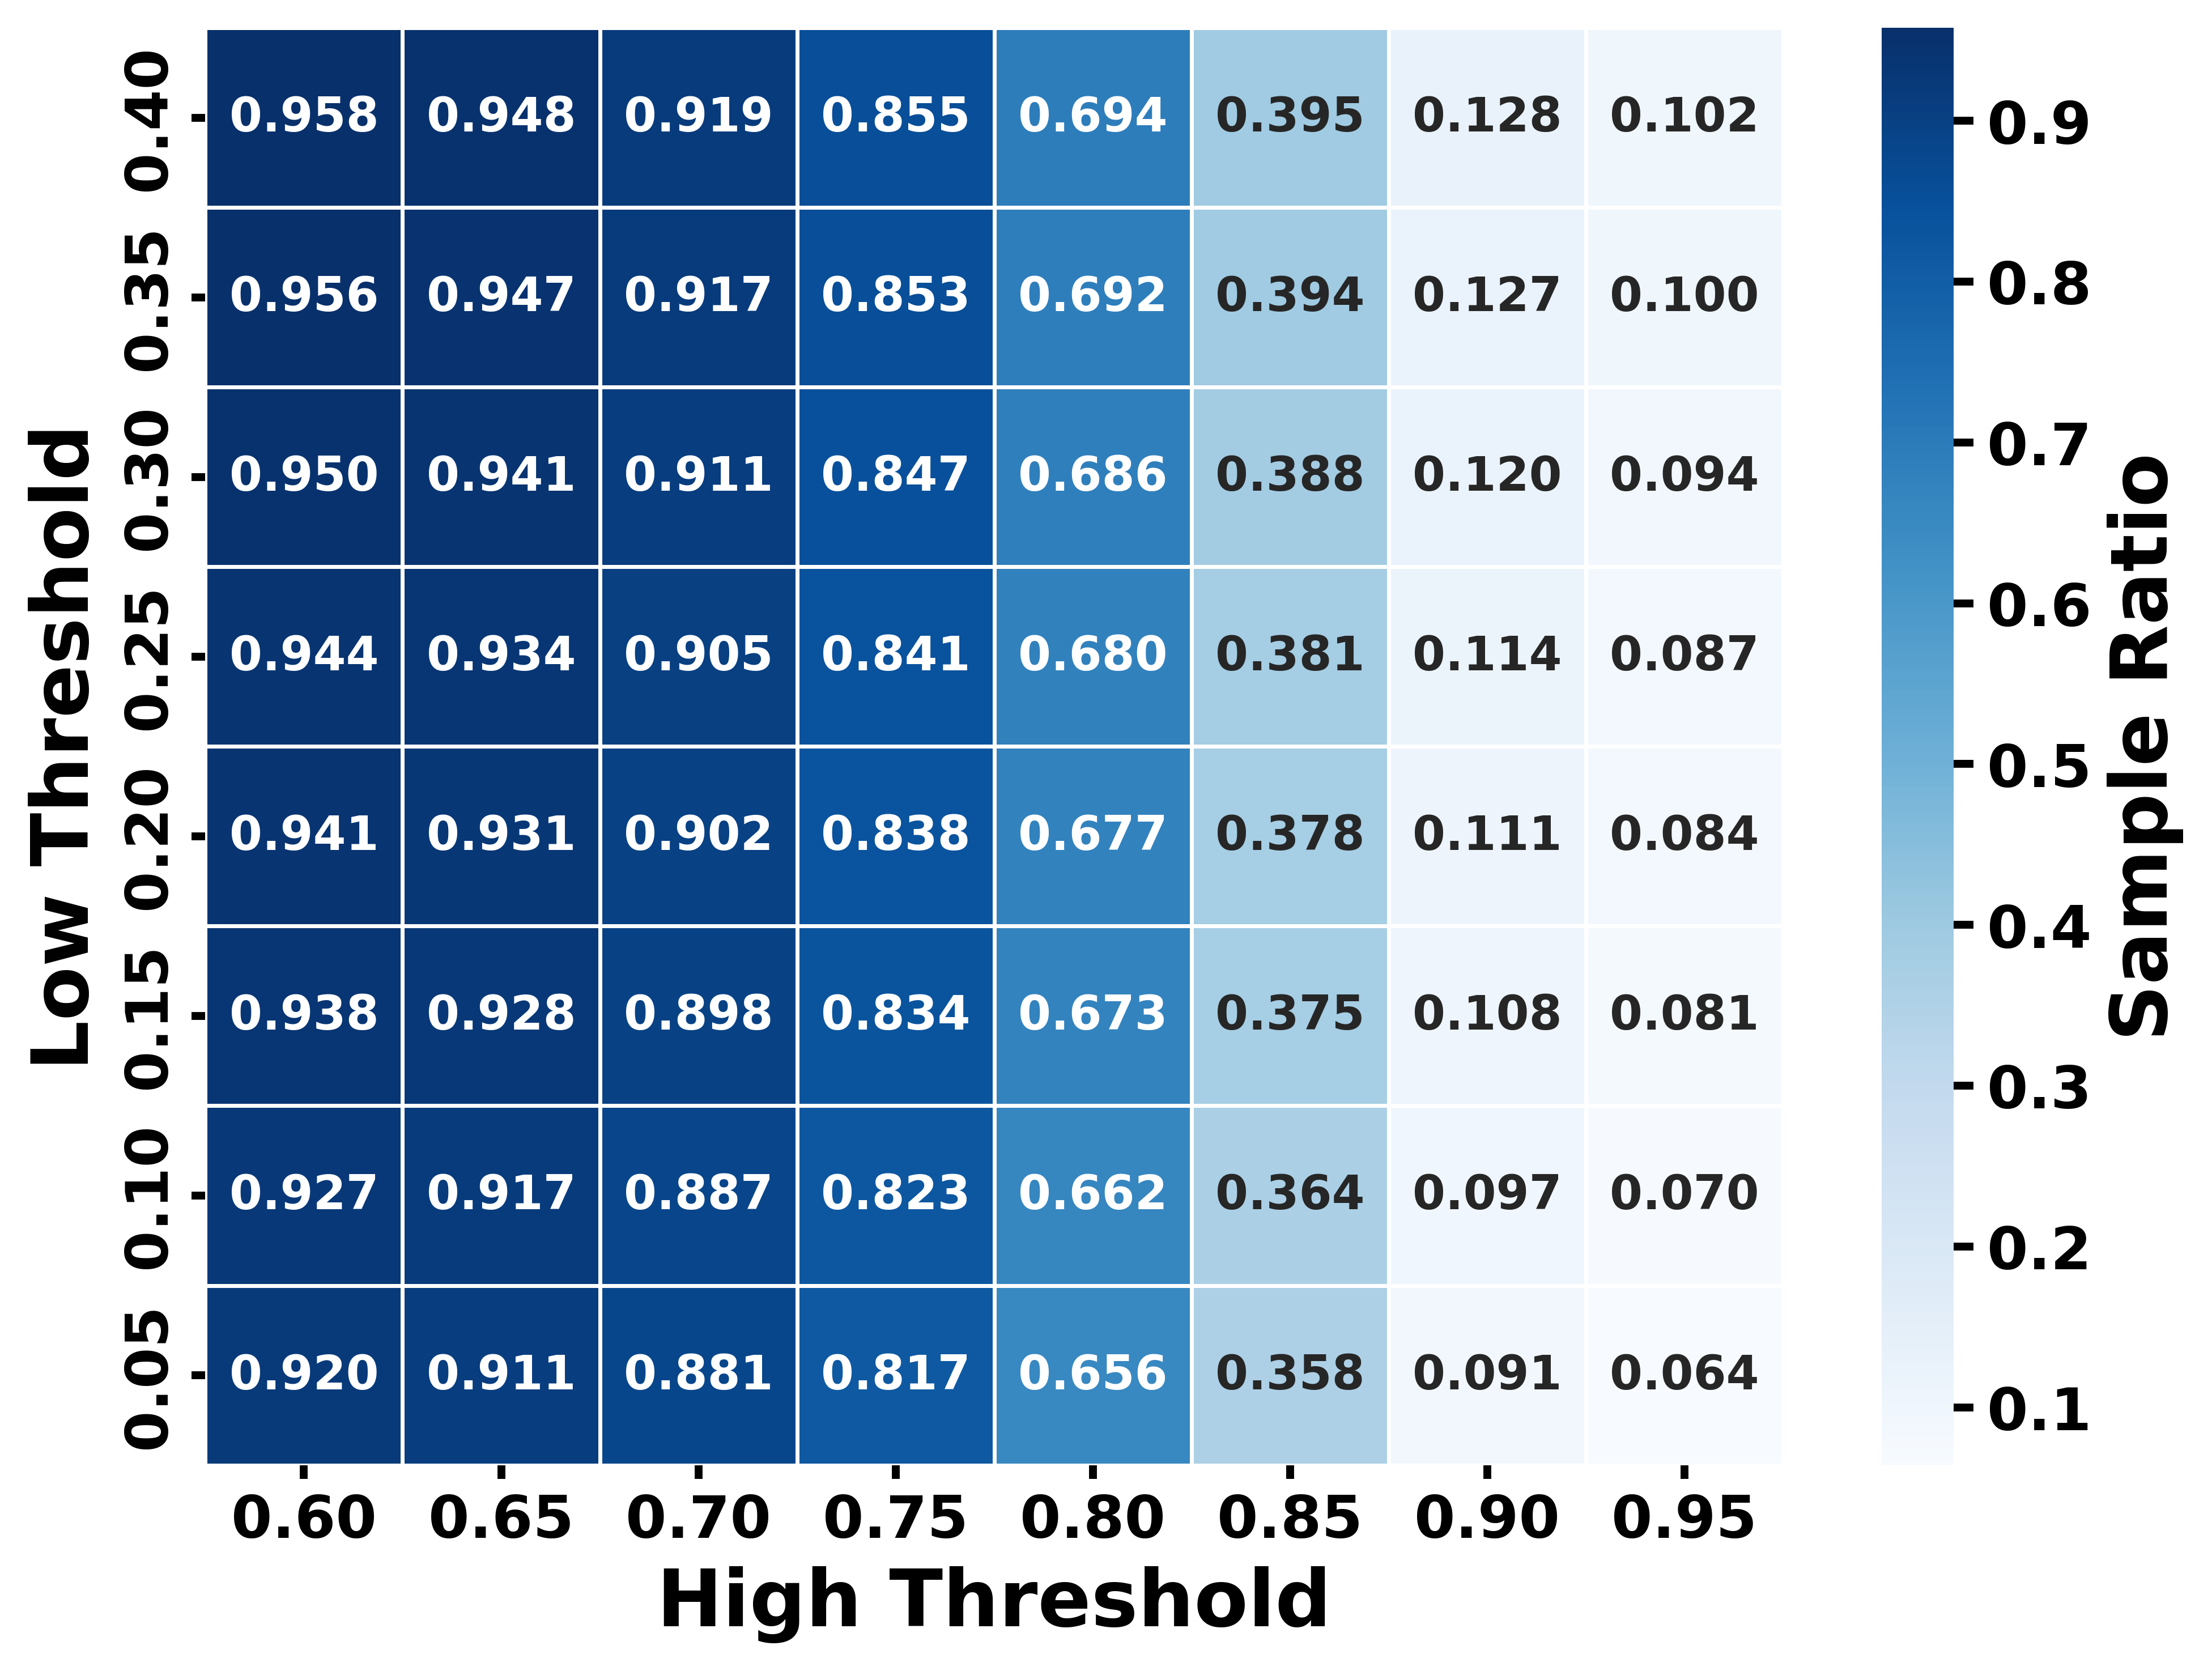

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ratio(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)
    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(sample_ratio_matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(sample_ratio_matrix)
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        sample_ratio_matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("Sample Ratio", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
plot_ratio(all_fold_probs,all_fold_labels)


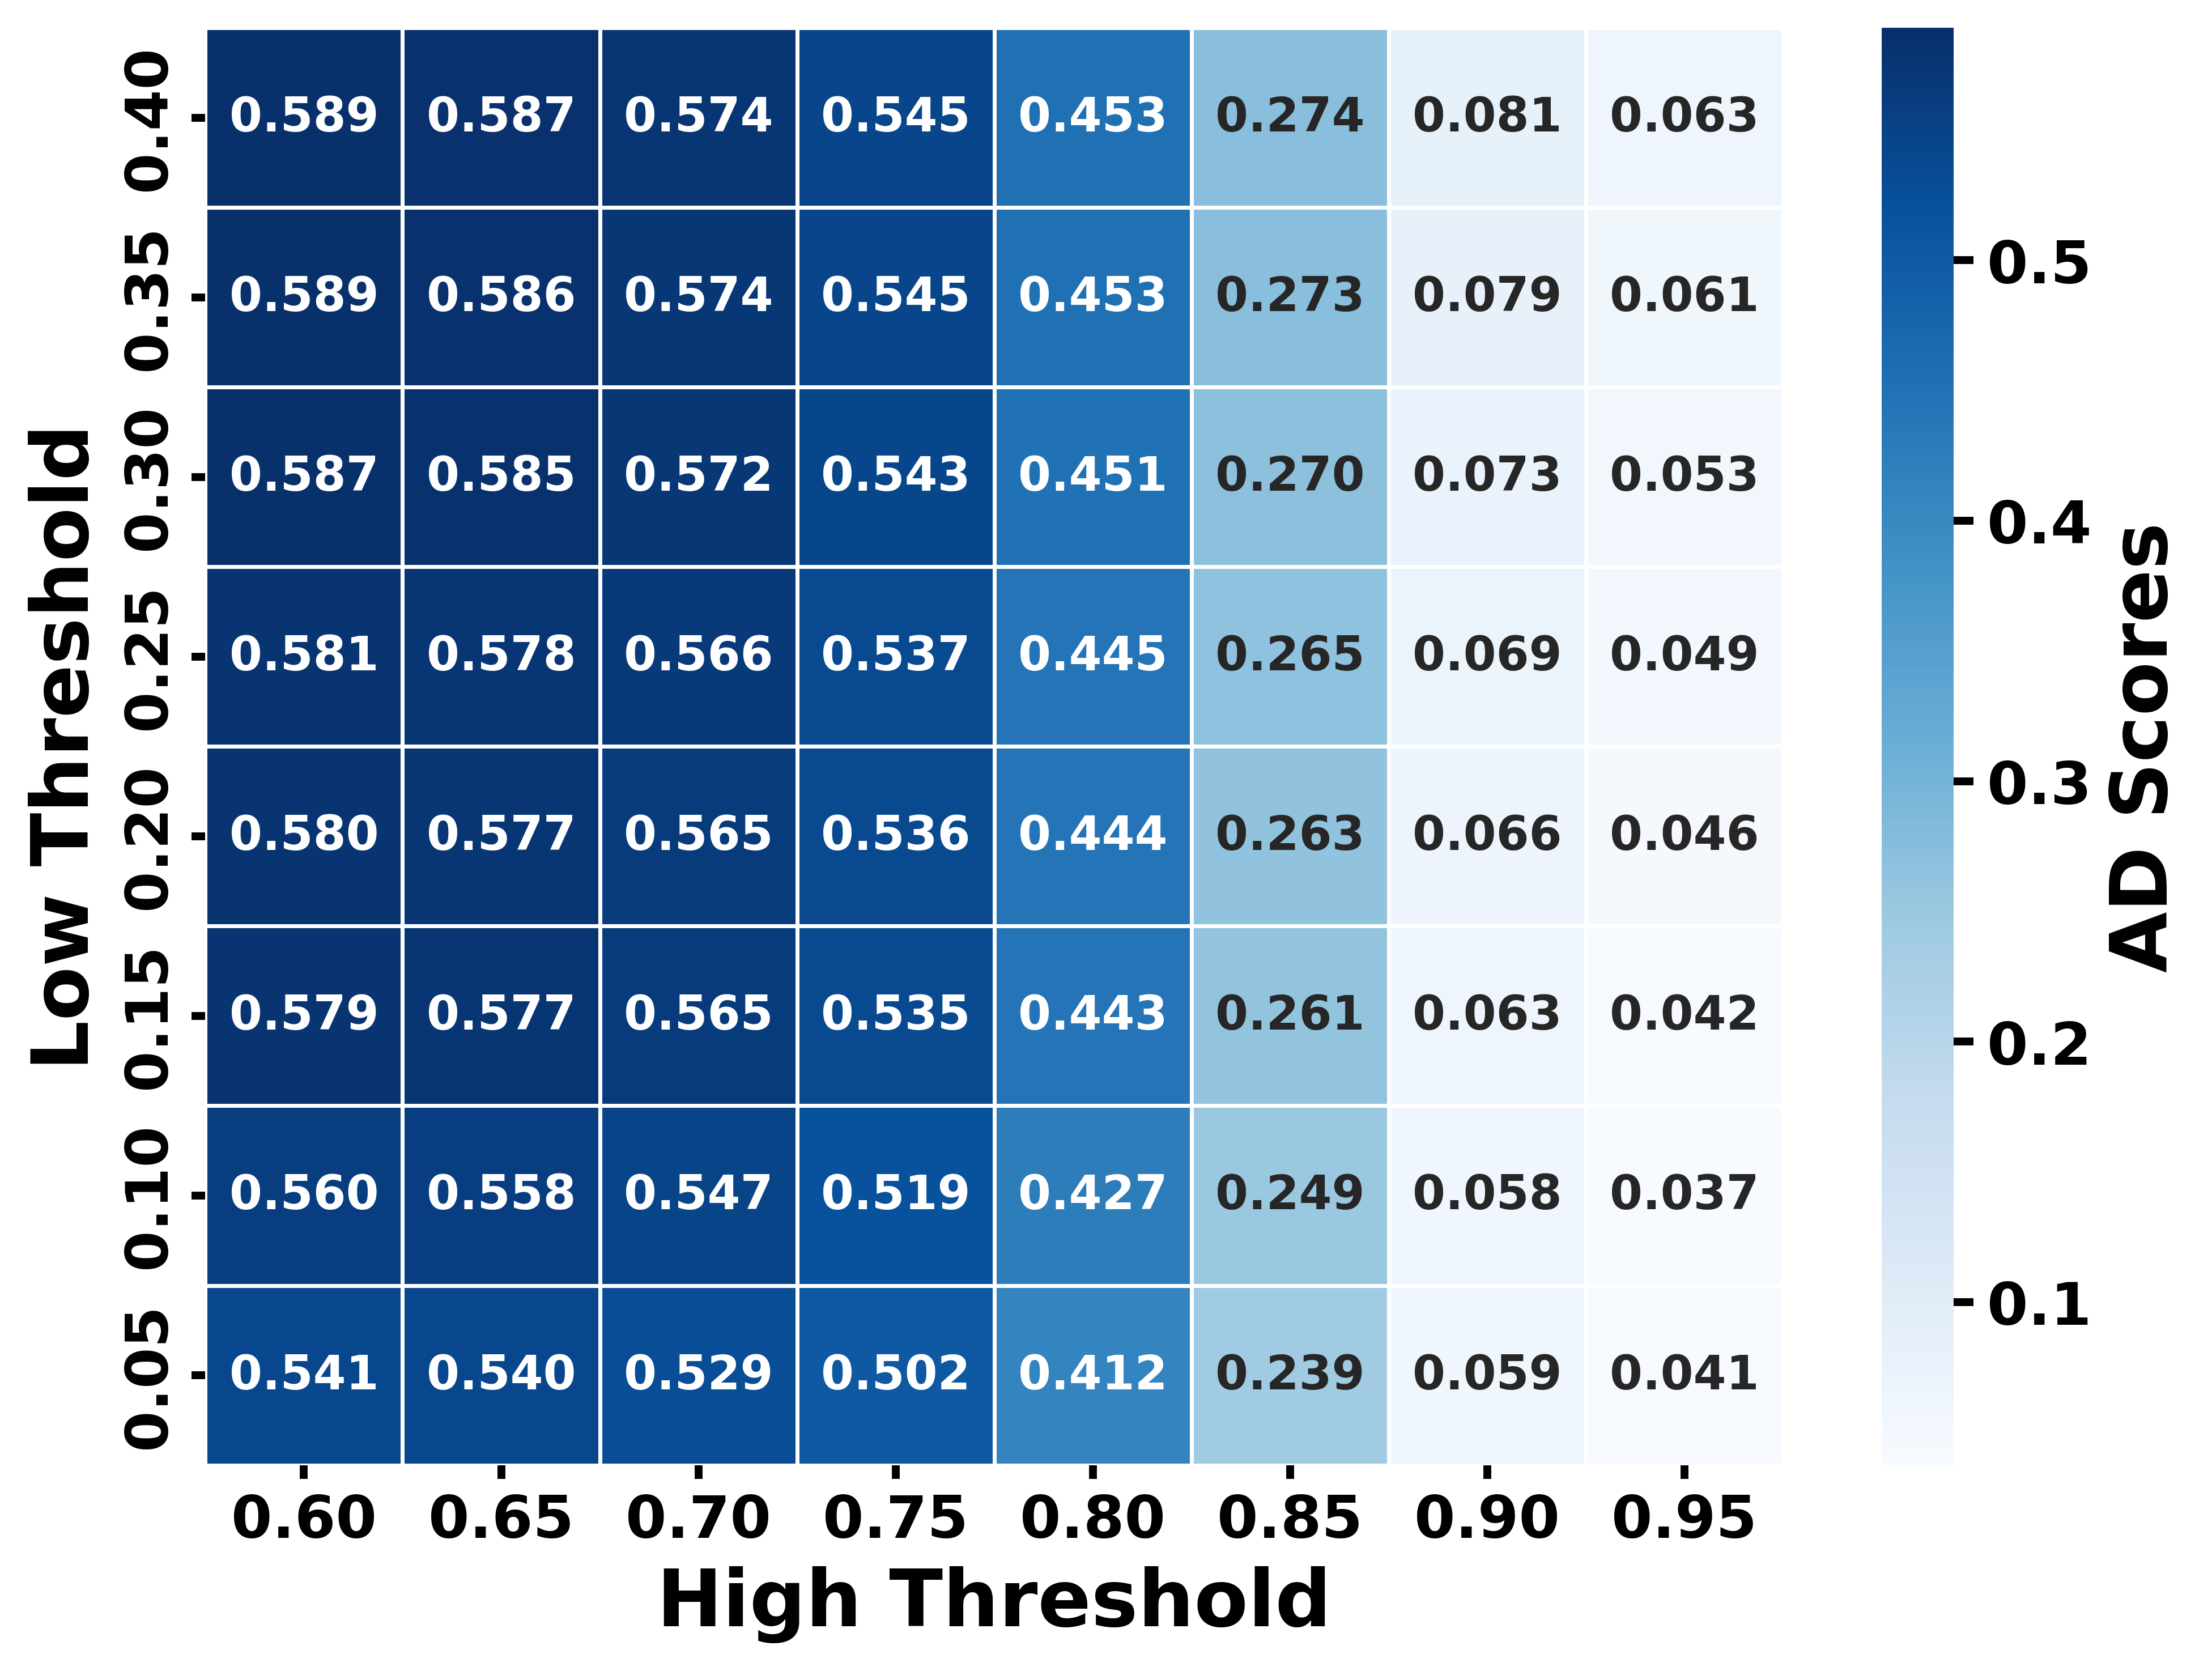

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

def plot_ADS(all_y_prob,all_y_true):


    # 设置上下界：low 从 0.2 到 0.4，每次步长 0.05，high 从 0.6 到 0.8，每次步长 0.05
    low_values = np.arange(0.05,0.41, 0.05)
    high_values = np.arange(0.6, 1, 0.05)

    # 用于保存每个 (low, high) 对应的样本占比
    sample_ratio_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本占比
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算样本占比
                sample_ratio = len(valid_idx) / len(all_y_true)
            else:
                sample_ratio = 0  # 如果没有有效样本，设置为 0
            
            sample_ratio_matrix[i, j] = sample_ratio

        # 用于保存每个 (low, high) 对应的 AUC-ROC
    auc_matrix = np.zeros((len(low_values), len(high_values)))

    # 对每个 (low, high) 组合，计算符合条件的样本数目和 AUC-ROC
    for i, low in enumerate(low_values):
        for j, high in enumerate(high_values):
            # 筛选出符合条件的样本
            valid_idx = np.where((all_y_prob <= low) | (all_y_prob >= high))[0]
            
            if len(valid_idx) > 0:  # 只有当 valid_idx 非空时才计算 AUC-ROC
                auc_score = roc_auc_score(all_y_true[valid_idx], all_y_prob[valid_idx])
            else:
                auc_score = np.nan  # 如果没有有效样本，设置为 0 或 NaN
            
            auc_matrix[i, j] = auc_score

    matrix = auc_matrix*sample_ratio_matrix
    
    # 创建图形
    plt.figure(figsize=(8, 6), dpi=500)

    vmin = np.min(matrix)  # 最小值)  # 最小值
    #vmax = np.max(accuracy_matrix) * 1.2 # 将最大值减少到最大值的95%
    vmax = np.max(matrix) 
    yanse = (vmax+vmin)/2

    

    # 创建带边框的热力图
    ax = sns.heatmap(
        matrix,
        annot=True,              # 在格子中显示数值
        fmt=".3f",               # 保留3位小数
        cmap="Blues",            # 颜色表
        vmin=vmin, vmax=vmax,    # 颜色范围
        xticklabels=[f"{hv:.2f}" for hv in high_values],
        yticklabels=[f"{lv:.2f}" for lv in low_values],
        linewidths=1,            # 网格线宽度
        linecolor='white',       # 网格线颜色
        cbar_kws={"label": "Sample Ratio"},  # 颜色条标签
        annot_kws={"size": 12, "weight": "bold"}
    )
    ax.invert_yaxis()
    # 设置坐标轴标签和字体大小
    ax.set_xlabel("High Threshold", fontsize=20,fontweight='bold')
    ax.set_ylabel("Low Threshold", fontsize=20,fontweight='bold')
    ax.tick_params(labelsize=15, width=2)
    # **设置坐标轴刻度字体加粗**
    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')
    # 调整颜色条的字体大小
    cbar = ax.collections[0].colorbar
    #cbar.ax.tick_params(labelsize=15, width=3)  # 设置颜色条刻度字体大小
    # 设置颜色条刻度字体加粗
    cbar.ax.yaxis.set_tick_params(labelsize=15, width=2, length=5)
    for label in cbar.ax.get_yticklabels():
        label.set_fontweight('bold')  # 让刻度标签加粗
    cbar.set_label("AD Scores", fontsize=20, fontweight='bold')  # 颜色条标题字体大小
    # 显示图
    plt.tight_layout()
    plt.show()



# 调用函数进行五折交叉验证并绘图
# 调用函数进行五折交叉验证并绘图
plot_ADS(all_fold_probs,all_fold_labels)